In [1]:
import numpy as np
import matplotlib.pyplot as plt
import collections
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
import time
import seaborn as sns
import pandas as pd

## Pep 8 on

In [2]:
# %load_ext pycodestyle_magic
# %pycodestyle_on

## Implementation code

### The base Graph K-Means algorithm is when centrality_measure='pagerank', and initialization='random'

### Side Note: 

Tried to improve code with parallelization techniques by changing the fit function to improve time.

Could not get the parrelization to work better, but ended up using voronoi_cells_method to improve the time.
    
The Run time for some measures will take long time. So Removed some of code. Other times left it as a markdown.

In [3]:
%%file Graph_k_Means.py
import numpy as np
import matplotlib.pyplot as plt
import collections
from joblib import Parallel, delayed
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
import random


class graph_parition_plot():
    def __init__(self, G, dic):
        self.G = G
        self.final_dic = dic
        self.pos = nx.kamada_kawai_layout(self.G, weight='weight')
        self.colors = ['red', 'green', 'blue', 'black', 'gold',
                       'grey', 'carol', 'cyan', 'm', 'firebrick',
                       'purple', 'khaki', 'orange', 'darkgreen']

    def draw_graph_partition(self,
                             node_size=40,
                             width=1,
                             edge_color='grey',
                             set_weight=None,
                             constant_value=None,
                             to_hd=True):
        '''
        draw the graph self.G
        '''
        if nx.is_connected(self.G) is False:

            raise ValueError("The graph is diconnected \
            , this function will terminate.")

        vals = np.unique(list(self.final_dic.values()))

        color_d = {}
        i = 0

        for v in vals:
            color_d[v] = self.colors[i]

            i = i + 1

        color_map = []
        if constant_value is not None:

            color_map = [0] * len(self.G.nodes())

        else:

            for i in range(0, len(self.G.nodes())):

                v = self.final_dic[i]
                color_map.append(color_d[v])
        nx.draw(self.G,
                pos=self.pos,
                node_size=node_size,
                edge_color=edge_color,
                width=width,
                node_color=color_map)
        if to_hd:
            plt.show(block=False)
            plt.savefig("Graph_test.png", format="PNG")
        return 1


class GraphKMeansBase():
    def __init__(self,
                 graph,
                 k,
                 n_iter=50,
                 metric='dijkstra',
                 relabel=True):
        """
        Initialize the Graph K-Means algorithm.

        Parameters:
        -----------
        graph : networkx graph
            The input graph for clustering.
        k : int
            Number of clusters.
        n_iter : int, optional (default=50)
            Number of iterations in the k-means algorithm.
        metric : str, optional (default='dijkstra')
            Metric used in the computation of
            the k-means algorithm on graph. Default is dijkstra.
        relabel : bool, optional (default=True)
            If True, relabels the graph nodes to integers.

        """
        # Graph clustering initialization
        if relabel:
            self.G = nx.convert_node_labels_to_integers(graph)
            print("The graph nodes have been relabeled to integers.")
        else:
            self.G = graph
        self.k = k  # Number of clusters

        if k > len(graph.nodes):
            raise ValueError("Number of clusters"
                             "cannot exceed number of"
                             "nodes in the input graph.")

        self.iters = n_iter
        self.final_dic = {}
        self.metric = metric
        self.distance = []
        self.converges = False
        self.steps = 0

    def getKeysByValue(self, dictOfElements, valueToFind):
        """
        Get keys by value from a dictionary.

        Parameters:
        -----------
        dictOfElements : dict
            The dictionary to search.
        valueToFind : any
            The value in the codomain of dictOfElements.

        Returns:
        --------
        list
            List of keys corresponding to the given value.

        """
        listOfKeys = list()
        listOfItems = dictOfElements.items()
        for item in listOfItems:
            if item[1] == valueToFind:
                listOfKeys.append(item[0])
        return listOfKeys

    def compute_metric(self, metric='dijkstra'):
        """
        Compute the distance matrix on the graph.

        Parameters:
        -----------
        metric : str, optional (default='dijkstra')
            Metric used in the computation of
            the distance matrix. Default is dijkstra.

        Returns:
        --------
        int
            Indicator of completion.

        """
        if metric == 'dijkstra':
            print("Computing the distance matrix on the graph.")
            self.distance = dict(nx.all_pairs_dijkstra_path_length(self.G))
        else:
            print("Computing communicability...")
            self.distance = nx.communicability(self.G)
            print("Done!")

        return 1

    def compute_subgraph_center(self, subgraph):
        """
        Compute the center of the subgraph
        using pagerank centrality.

        Parameters:
        -----------
        subgraph : networkx graph
            The subgraph for which to compute the center.

        Returns:
        --------
        any
            Center node of the subgraph.

        """
        d = nx.pagerank(subgraph, weight='weight')
        center = max(d, key=d.get)
        return center

    def fit(self):
        """
        Compute the k-means clustering of the graph.

        Returns:
        --------
        dict
            Dictionary mapping each node to its closest center.

        """
        # Compute the distance matrix
        self.compute_metric(self.metric)

        # Pick randomly k numbers from (0, len(G))
        nodes_k = random.sample(list(self.G.nodes()), self.k)

        current_centers = list(nodes_k)

        final_d = {}
        stable = 0  # Counter for convergence

        for i in range(0, self.iters):
            print("Doing iteration " + str(i))
            # Stage 1: Assigning each node to its closest center
            for node in self.G.nodes():
                distance2node = self.distance[node]
                dict_you_want = {c: distance2node[c]
                                 if c in distance2node else np.Infinity
                                 for c in current_centers}
                mincenter = min(dict_you_want, key=dict_you_want.get)
                final_d[node] = mincenter

            newcenters = []
            # Stage 2: Updating the centers based on the previous step
            for center in current_centers:
                subgraph_nodes = self.getKeysByValue(final_d, center)
                subgraph = self.G.subgraph(subgraph_nodes)
                center = self.compute_subgraph_center(subgraph)
                newcenters.append(center)

            # Stage 3: Check for convergence
            if sorted(current_centers) == sorted(newcenters):
                stable += 1
                if stable == 3:
                    print("Algorithm converges with " + str(i) + " steps.")
                    self.converges = True
                    self.steps = i
                    break

            # Stage 4: Update the centers
            # if not converged and get ready for the next loop
            current_centers = newcenters
        print("Hello!")
        if stable != 3:
            print("Algorithm did not converge")
        else:
            self.converges = True
            self.converges = True

        self.final_dic = final_d
        print("Done!")
        return final_d


class GraphKMeans():
    def __init__(self,
                 graph,
                 k,
                 n_iter=10,
                 metric='dijkstra',
                 relabel=True,
                 centrality_measure='pagerank',
                 initialization='random',
                 fitting_method="basic"):
        """
        Initialize the Graph K-Means algorithm.

        Parameters:
        -----------
        graph : networkx graph
            The input graph for clustering.
        k : int
            Number of clusters.
        n_iter : int, optional (default=50)
            Number of iterations in the k-means algorithm.
        metric : str, optional (default='dijkstra')
            Metric used in the computation of the k-means algorithm
            on graph.
            Default is dijkstra.
        relabel : bool, optional (default=True)
            If True, relabels the graph nodes to integers.
        centrality_measure : str, optional (default='pagerank')
            Centrality measure used for determining cluster centers.
            Options: 'pagerank', 'degree', 'eigenvector', etc.
        initialization : str, optional (default='random')
            Initialization strategy for selecting initial cluster centers.
            Options: 'random', 'kmeans++', 'degree', 'betweenness', etc.

        """
        if relabel:
            self.G = nx.convert_node_labels_to_integers(graph)
            print("The graph nodes have been relabeled to integers.")
        else:
            self.G = graph
        self.k = k  # Number of clusters

        if k > len(graph.nodes):
            raise ValueError("Number of clusters cannot exceed \
            number of nodes in the input graph.")

        if n_iter <= 0:
            raise ValueError("Invalid Number of Iteration")

        self.iters = n_iter
        self.metric = metric
        self.distance = {}
        self.centrality_measure = centrality_measure
        self.initialization = initialization
        self.converges = False
        self.steps = 0
        self.fitting_method = fitting_method

    def compute_metric(self, metric='dijkstra'):
        """
        Compute the distance matrix on the graph.

        Parameters:
        -----------
        metric : str, optional (default='dijkstra')
            Metric used in the computation of the distance matrix.
            Default is dijkstra.

        Returns:
        --------
        dict
            Distance matrix on the graph.

        """
        if metric == 'dijkstra':
            print("Computing the distance matrix on the graph.")
            self.distance = dict(nx.all_pairs_dijkstra_path_length(self.G))
        elif metric == 'communicability':
            self.distance = nx.communicability(self.G)
        else:
            raise ValueError("Invalid metric specified.")

        return self.distance

    def compute_subgraph_center(self, subgraph):
        """
        Compute the center of the subgraph
        using the specified centrality measure.

        Parameters:
        -----------
        subgraph : networkx graph
            The subgraph for which to compute the center.

        Returns:
        --------
        any
            Center node of the subgraph.

        """
        if self.centrality_measure == 'pagerank':
            d = nx.pagerank(subgraph, weight='weight')
        elif self.centrality_measure == 'betweenness':
            d = nx.betweenness_centrality(subgraph, weight='weight')
        elif self.centrality_measure == 'eigenvector':
            d = nx.eigenvector_centrality(subgraph, weight='weight',
                                          max_iter=1000, tol=1e-8)
        elif self.centrality_measure == 'degree':
            d = nx.degree_centrality(subgraph)
        elif self.centrality_measure == 'current_flow_betweenness_centrality':
            d = nx.betweenness_centrality(subgraph, weight='weight')
        elif (self.centrality_measure ==
              'current_flow_betweenness_centrality_subset'):
            sources = list(subgraph.nodes())
            targets = list(subgraph.nodes())
            d = nx.betweenness_centrality_subset(subgraph,
                                                 sources=sources,
                                                 targets=targets,
                                                 weight='weight')
        elif self.centrality_measure == 'current_flow_closeness_centrality':
            d = nx.current_flow_closeness_centrality(subgraph, weight='weight')
        elif (self.centrality_measure ==
              'approximate_current_flow_betweenness_centrality'):
            aprox = nx.approximate_current_flow_betweenness_centrality
            d = aprox(subgraph, weight='weight')
        elif self.centrality_measure == 'information_centrality':
            d = nx.information_centrality(subgraph, weight='weight')
        elif self.centrality_measure == 'voterank':
            d = nx.voterank(subgraph)
        elif self.centrality_measure == 'percolation_centrality':
            d = nx.percolation_centrality(subgraph, weight='weight')
        elif self.centrality_measure == 'subgraph_centrality':
            d = nx.subgraph_centrality(subgraph)
        elif self.centrality_measure == 'subgraph_centrality_exp':
            d = nx.subgraph_centrality_exp(subgraph)
        elif self.centrality_measure == 'estrada_index':
            d = nx.estrada_index(subgraph)
        elif self.centrality_measure == 'second_order_centrality':
            d = nx.second_order_centrality(subgraph)
        elif self.centrality_measure == 'load_centrality':
            d = nx.load_centrality(subgraph, weight='weight')
        elif self.centrality_measure == 'closeness_centrality':
            d = nx.closeness_centrality(subgraph)
        elif self.centrality_measure == 'harmonic_centrality':
            d = nx.harmonic_centrality(subgraph)
        elif self.centrality_measure == 'hits':
            d = nx.hits(subgraph)
        elif self.centrality_measure == 'katz_centrality':
            d = nx.katz_centrality(subgraph, weight='weight')
        else:
            raise ValueError("Invalid centrality measure")

        center = max(d, key=d.get)
        return center

    def initialize_centers(self):
        """
        Initialize cluster centers based on
        the specified initialization strategy.

        Returns:
        --------
        list
            List of initial cluster centers.

        """
        if self.initialization == 'random':
            return random.sample(list(self.G.nodes()), self.k)
        elif self.initialization == 'kmeans++':
            # Implement k-means++ initialization strategy
            nodes = list(self.G.nodes())
            centers = [random.choice(nodes)]
            while self.k > len(centers):
                distances = [min(
                    [nx.shortest_path_length(self.G, c, node)
                     for c in centers]) for node in self.G.nodes()]
                total_distance = sum(distances)
                probabilities = [dist / total_distance for dist in distances]
                random_node = random.choices(list(self.G.nodes()),
                                             weights=probabilities, k=1)[0]
                centers.append(random_node)

            return centers
        elif self.initialization == 'betweenness':
            betweenness = nx.betweenness_centrality(self.G, weight='weight')
            sorted_betweenness = sorted(betweenness,
                                        key=betweenness.get,
                                        reverse=True)
            return sorted_betweenness[:self.k]
        elif self.initialization == 'degree':
            degree = dict(self.G.degree())
            sorted_degrees = sorted(degree,
                                    key=degree.get,
                                    reverse=True)
            return sorted_degrees[:self.k]
        else:
            raise ValueError("Invalid initialization strategy")

    def fit_voronoi_cells_method(self):
        '''
        Purpose :
        _________
            compute the kmeans of the graph G using
            the method specified in the constructor

        Ouput :
        _______
            a dictionary final_d :Graph.Nodes()-> Set of all centers
                every node is assocaited to its closest center

        Remarks:
        ________
            Usually faster than the explicit method, however,
            the input graph must be connected
            for the voronoi cells to be utilized.
            If the graph is disconnected,
            then use the other fitting method,
            fit_explicit_method, for computation.
        '''

        if nx.is_connected(self.G) is False:
            self.fit_basic()
        nodes_k = random.sample(list(self.G.nodes()), self.k)
        current_centers = nodes_k
        final_d = {}
        stable = 0
        cells = []
        for i in range(0, self.iters):
            print("Doing iteration "+str(i))
            cells = nx.voronoi_cells(self.G, current_centers, weight='weight')
            newcenters = []

            for cell in cells.values():
                subgraph = self.G.subgraph(cell)
                center = self.compute_subgraph_center(subgraph)
                newcenters.append(center)
            if sorted(current_centers) == sorted(newcenters):
                stable = stable + 1
                if stable == 3:
                    print("Algorithm converges with " + str(i) + " steps.")
                    self.steps = i
                    break
            current_centers = newcenters
        if stable != 3:
            print("Algorithm did not converge")
        else:
            self.converges = True

        for key, value in zip(cells.keys(), cells.values()):
            for v in value:
                final_d[v] = key

        self.final_dic = final_d

        print("Done!")
        return final_d

    def fit_basic(self):
        """
        Compute the k-means clustering of the graph.

        Returns:
        --------
        dict
            Dictionary mapping each node to its closest center.

        """
        self.compute_metric(self.metric)

        current_centers = self.initialize_centers()

        final_d = {}
        stable = 0

        for i in range(self.iters):
            print("Doing iteration", i)
            # Step 1: Assigning each node to its closest center
            for node in self.G.nodes():
                distance2node = self.distance[node]
                dict_you_want = {c: distance2node.get(c, np.inf)
                                 for c in current_centers}
                mincenter = min(dict_you_want, key=dict_you_want.get)
                final_d[node] = mincenter
            # step 2
            newcenters = [
                self.compute_subgraph_center(
                    self.G.subgraph([node
                                     for node, c in final_d.items()
                                     if c == center]))
                for center in current_centers]

            # Step 3: Check the convergence
            if sorted(current_centers) == sorted(newcenters):
                stable += 1
                if stable == 3:
                    print("Algorithm converges with", i, "steps.")
                    self.steps = i
                    break

            # Step 4: Update the centers if not converged
            current_centers = newcenters

        if stable != 3:
            print("Algorithm did not converge")
        else:
            self.converges = True

        self.final_dic = final_d
        print("Done!")
        return final_d

    def fit(self):
        if self.fitting_method == "voronoi_cells_method":
            return self.fit_voronoi_cells_method()
        else:
            return self.fit_basic()

Overwriting Graph_k_Means.py


### Side Note:

Tried to implement hits, katz_centrality, estrada_index, and voterank. Did not work!

## Import my implementation

In [4]:
from Graph_k_Means import *

## Helper functions

In [5]:
def running_time_base(graph,
                      k,
                      n_iter=10,
                      initialization='random',
                      centrality_measure='pagerank',
                      num_iterations=1):
    """
        Compute the running time of the
        the Base Graph K-Means algorithm.

        Parameters:
        -----------
        graph : networkx graph
        The input graph for clustering.
        k : int
            Number of clusters.
        n_iter : int, optional (default=50)
            Number of iterations in the k-means algorithm.
        initialization : str, optional (default='random')
            Initialization strategy for
            selecting initial cluster centers.
            Options: 'random', 'kmeans++', 'degree', etc.
        centrality_measure : str, optional (default='pagerank')
            Centrality measure used for determining cluster centers.
            Options: 'pagerank', 'degree', 'eigenvector', etc.
        num_iterations : int
            The number of iterations

        Returns:
        --------
        float
            The running time of the Graph K-Means algorithm in seconds.
    """
    running_times = []
    num_converged = 0
    for i in range(num_iterations):
        start_time = time.time()
        graph_kmeans = GraphKMeansBase(graph,
                                       k,
                                       n_iter=n_iter)
        graph_kmeans.fit()
        end_time = time.time()

    running_times = end_time - start_time
    return np.mean(running_times)


def running_time_base_graph(graph,
                            k, n_iter=10,
                            initialization='random',
                            centrality_measure='pagerank',
                            num_iterations=1):
    """
        Compute the running time of the
        the Base Graph K-Means algorithm.

        Parameters:
        -----------
        graph : networkx graph
        The input graph for clustering.
        k : int
            Number of clusters.
        n_iter : int, optional (default=50)
            Number of iterations in the k-means algorithm.
        initialization : str, optional (default='random')
            Initialization strategy for
            selecting initial cluster centers.
            Options: 'random', 'kmeans++', 'degree', etc.
        centrality_measure : str, optional (default='pagerank')
            Centrality measure used for determining cluster centers.
            Options: 'pagerank', 'degree', 'eigenvector', etc.
        num_iterations : int
            The number of iterations

        Returns:
        --------
        float
            The running time of the Graph K-Means algorithm in seconds.
    """
    running_times = []
    num_converged = 0
    for i in range(num_iterations):
        start_time = time.time()
        graph_kmeans = GraphKMeansBase(graph,
                                       k,
                                       n_iter=n_iter)
        graph_kmeans.fit()
        end_time = time.time()
        running_times.append(end_time - start_time)

    return (running_times)


def running_time_my_graph(graph,
                          k, n_iter=10,
                          initialization='random',
                          centrality_measure='pagerank',
                          num_iterations=1):
    """
        Compute the running time of
        my Graph K-Means algorithm.

        Parameters:
        -----------
        graph : networkx graph
        The input graph for clustering.
        k : int
            Number of clusters.
        n_iter : int, optional (default=50)
            Number of iterations in the k-means algorithm.
        initialization : str, optional (default='random')
            Initialization strategy for
            selecting initial cluster centers.
            Options: 'random', 'kmeans++', 'degree', etc.
        centrality_measure : str, optional (default='pagerank')
            Centrality measure used for determining cluster centers.
            Options: 'pagerank', 'degree', 'eigenvector', etc.
        num_iterations : int
            The number of iterations

        Returns:
        --------
        float
            The running time of the Graph K-Means algorithm in seconds.
    """
    running_times = []
    num_converged = 0
    for i in range(num_iterations):
        start_time = time.time()
        graph_kmeans = GraphKMeans(graph,
                                   k,
                                   n_iter=n_iter,
                                   fitting_method='voronoi_'
                                   'cells_method')
        graph_kmeans.fit()
        end_time = time.time()
        running_times.append(end_time - start_time)

    return (running_times)


def running_time(graph,
                 k, n_iter=50,
                 initialization='random',
                 centrality_measure='pagerank',
                 num_iterations=1):
    """
        Compute the running time of the Graph K-Means algorithm.

        Parameters:
        -----------
        graph : networkx graph
        The input graph for clustering.
        k : int
            Number of clusters.
        n_iter : int, optional (default=50)
            Number of iterations in the k-means algorithm.
        initialization : str, optional (default='random')
            Initialization strategy for
            selecting initial cluster centers.
            Options: 'random', 'kmeans++', 'degree', etc.
        centrality_measure : str, optional (default='pagerank')
            Centrality measure used for determining cluster centers.
            Options: 'pagerank', 'degree', 'eigenvector', etc.
        num_iterations : int
            The number of iterations

        Returns:
        --------
        float
            The running time of the Graph K-Means algorithm in seconds.
    """
    running_times = []
    num_converged = 0
    while num_converged != num_iterations:
        start_time = time.time()
        graph_kmeans = GraphKMeans(graph,
                                   k,
                                   n_iter=n_iter,
                                   initialization=initialization,
                                   centrality_measure=centrality_measure,
                                   fitting_method='voronoi_cells_method')
        graph_kmeans.fit()
        end_time = time.time()
        converged = graph_kmeans.converges
        if converged:
            running_times.append(end_time - start_time)
            num_converged += 1
        if num_converged == num_iterations:
            break

    return np.mean(running_times)


def run_kmeans_trials(graph,
                      num_trials=100,
                      k=4,
                      n_iter=10,
                      initialization='random',
                      centrality_measure="pagerank"):
    """
    Run multiple trials of Graph K-Means on the given graph
    and collect convergence information.

    Parameters:
    -----------
    graph : networkx graph
        The input graph for clustering.
    num_trials : int, optional (default=100)
        Number of trials to run.
    k : int, optional (default=4)
        Number of clusters.
    n_iter : int, optional (default=10)
        Number of iterations in the k-means algorithm.
    initialization : str, optional (default='random')
        Initialization strategy for selecting initial cluster centers.
        centrality_measure

    Returns:
    --------
    tuple
        A tuple containing:
        - converge_list: A list indicating convergence (1) or
        not (0) for each trial.
        - steps_list: A list containing the number
        of steps for each trial.
    """
    converge_list = []
    steps_list = []
    num_converged = 0
    num_not_converged = 0

    for i in range(num_trials):
        graph_k_means = GraphKMeans(graph,
                                    k=k,
                                    n_iter=n_iter,
                                    initialization=initialization,
                                    centrality_measure=centrality_measure,
                                    fitting_method='voronoi_cells_method')
        d = graph_k_means.fit()
        converge = graph_k_means.converges
        steps = graph_k_means.steps
        steps_list.append(steps)
        converge = 1 if converge else 0
        converge_list.append(converge)

        if converge:
            num_converged += 1
        else:
            num_not_converged += 1

    return converge_list, steps_list


def run_kmeans_trials_base(graph,
                           num_trials=100,
                           k=4,
                           n_iter=10):
    """
    Run multiple trials of Graph K-Means on the given graph
    and collect convergence information.

    Parameters:
    -----------
    graph : networkx graph
        The input graph for clustering.
    num_trials : int, optional (default=100)
        Number of trials to run.
    k : int, optional (default=4)
        Number of clusters.
    n_iter : int, optional (default=10)
        Number of iterations in the k-means algorithm.

    Returns:
    --------
    tuple
        A tuple containing:
        - converge_list: A list indicating convergence
        (1) or
        not (0) for each trial.
        - steps_list: A list containing the number
        of steps for each trial.
    """
    converge_list = []
    steps_list = []
    num_converged = 0
    num_not_converged = 0

    for i in range(num_trials):
        graph_k_means = GraphKMeansBase(graph,
                                        k=k,
                                        n_iter=n_iter)
        d = graph_k_means.fit()
        converge = graph_k_means.converges
        steps = graph_k_means.steps
        steps_list.append(steps)
        converge = 1 if converge else 0
        converge_list.append(converge)

        if converge:
            num_converged += 1
        else:
            num_not_converged += 1

    return converge_list, steps_list


def plot_convergence_histogram(converge_list):
    """
    Plot a histogram showing the distribution of convergence.

    Parameters:
    -----------
    converge_list : list
        A list indicating convergence (1) or not (0) for each trial.
    """
    plt.figure(figsize=(8, 6))
    plt.hist(converge_list,
             bins=2,
             color='skyblue',
             edgecolor='black',
             alpha=0.7)
    plt.title('Distribution of Convergence '
              'in Graph K-Means over 100 Trials')
    plt.xlabel('Convergence (0: Not Converged, 1: Converged)')
    plt.ylabel('Frequency')
    plt.xticks([0.25, 0.75], ['Not Converged', 'Converged'])
    plt.grid(True)
    plt.show()


def plot_convergence_steps(converge_list, steps_list):
    """
    Plot a histogram showing the distribution of minimum steps for convergence.

    Parameters:
    -----------
    converge_list : list
        A list indicating convergence (1) or not (0) for each trial.
    steps_list : list
        A list containing the number of steps for each trial.
    """
    converged_steps = [steps_list[i] for i in range(len(steps_list))
                       if converge_list[i] == 1]
    plt.figure(figsize=(8, 6))
    plt.hist(converged_steps,
             bins='auto',
             color='skyblue',
             edgecolor='black',
             alpha=0.7)
    plt.title('Distribution of Minimum Steps for Convergence in Graph K-Means')
    plt.xlabel('Minimum Steps for Convergence')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


def basic_run_time(graph,
                   k,
                   n_iter=50,
                   initialization='random',
                   centrality_measure='pagerank',
                   num_iterations=10):
    """
    Measure the running time of the GraphKMeans algorithm.

    Parameters:
    -----------
    graph : networkx graph
        The input graph for clustering.
    k : int
        Number of clusters.
    n_iter : int, optional (default=50)
        Number of iterations in the k-means algorithm.
    initialization : str, optional (default='random')
        Initialization strategy for selecting initial cluster centers.
    centrality_measure : str, optional (default='pagerank')
        Centrality measure used for determining cluster centers.
    num_iterations : int
        Number of iterations to run the experiment for.

    Returns:
    --------
    list
        A list containing the running times for each iteration.
    """
    running_times = []
    num_converged = 0
    while num_converged != 10:
        start_time = time.time()
        graph_kmeans = GraphKMeans(graph,
                                   k,
                                   n_iter=n_iter,
                                   initialization=initialization,
                                   centrality_measure=centrality_measure,
                                   fitting_method='voronoi_cells_method')
        graph_kmeans.fit()
        end_time = time.time()
        converged = graph_kmeans.converges
        if converged:
            running_times.append(end_time - start_time)
            num_converged += 1
            if num_converged == num_iterations:
                break
    return running_times

# Explore Base Model and My Model.

### To improve the running time speed used code on 'voronoi_cells_method'

The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Doing iteration 9
Hello!
Algorithm did not converge
Done!


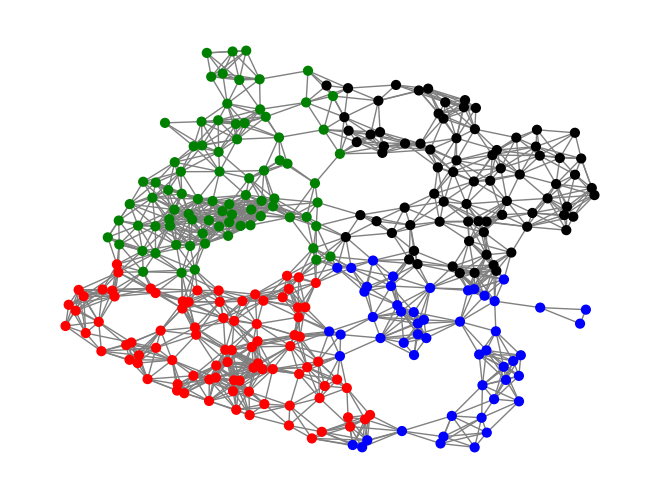

False

<Figure size 640x480 with 0 Axes>

In [6]:
G = nx.random_geometric_graph(300, .115)

graph_k_means = GraphKMeansBase(G,
                                k=4,
                                n_iter=10)
d = graph_k_means.fit()

draw = graph_parition_plot(G, d)
draw.draw_graph_partition()

graph_k_means.converges

In [7]:
G = nx.random_geometric_graph(400, .115)
my_run_time = running_time_my_graph(G,
                                    4,
                                    n_iter=10,
                                    initialization='random',
                                    centrality_measure='pagerank',
                                    num_iterations=100)

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Algorithm converges with 8 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Doing iteration 9
Algorithm did not converge
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Algorithm converges with 6 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing it

Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Doing iteration 9
Algorithm did not converge
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doin

Doing iteration 7
Doing iteration 8
Doing iteration 9
Algorithm did not converge
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Doing iteration 9
Algorithm did not converge
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing itera

In [8]:
base_run_time = running_time_base_graph(G,
                                        4,
                                        n_iter=10,
                                        initialization='random',
                                        centrality_measure='pagerank',
                                        num_iterations=100)

The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Doing iteration 9
Hello!
Algorithm did not converge
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Hello!
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Algorithm converges with 7 steps.
Hello!
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing it

Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Hello!
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Algorithm converges with 6 steps.
Hello!
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Hello!
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Algorithm converges with 6 steps.
Hello!
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing it

Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Doing iteration 9
Hello!
Algorithm did not converge
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Hello!
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Doing iteration 9
Hello!
Algorithm did not converge
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7


Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Hello!
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Hello!
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Hello!
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Doing iteration 9
Hello!
Algorithm did not converge
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the grap

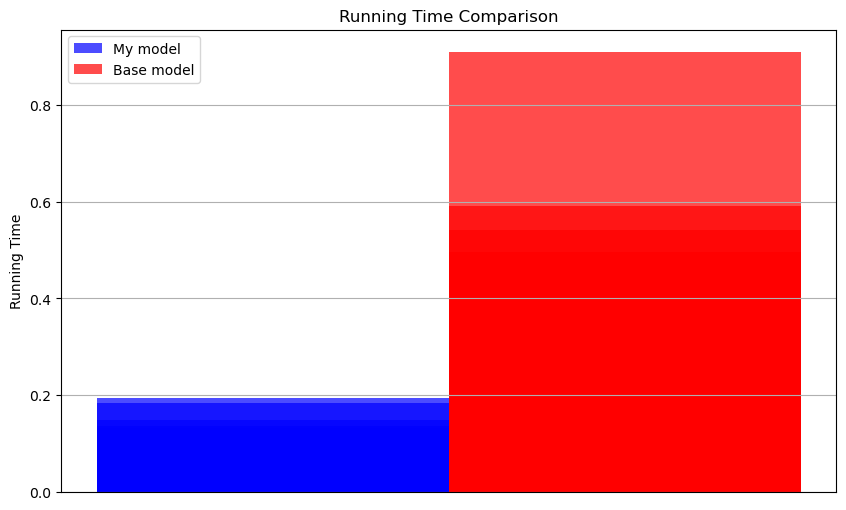

In [9]:
plt.figure(figsize=(10, 6))
bar_width = 0.35

# Plotting
plt.bar(0, my_run_time, label="My model", color='b',
        alpha=0.7, width=bar_width)
plt.bar(bar_width, base_run_time, label="Base model",
        color='r', alpha=0.7, width=bar_width)
plt.xticks([], [])
plt.ylabel('Running Time')
plt.title('Running Time Comparison')
plt.legend()
plt.grid(True)
plt.show()

## Insights

My model significantly improves from my model. Will need to fine tune more

# 1 Variations Exploration

# Experiment each Centrality

In [10]:
def experiment_each_centrality(graph, k, n_iter=50,
                               initialization='random',
                               centrality_measures='pagerank'):
    """
    Perform an experiment to evaluate the Graph K-Means algorithm
    using different centrality measures.

    Parameters:
    -----------
    graph : networkx graph
        The input graph for clustering.
    k : int
        Number of clusters.
    n_iter : int, optional (default=50)
        Number of iterations in the k-means algorithm.
    initialization : str, optional (default='random')
        Initialization strategy for selecting initial cluster centers.
    centrality_measures : list of str, optional (default='pagerank')
        List of centrality measures used for determining cluster centers.
        Options: 'pagerank', 'betweenness', 'eigenvector', 'degree', etc.

    Returns:
    --------
    dict:
        A dictionary containing the results of the experiment.
    """
    results = {}
    for centrality_measure in centrality_measures:
        print("-"*100)
        print(centrality_measure)
        graph_k_means = GraphKMeans(graph,
                                    k=k,
                                    n_iter=n_iter,
                                    centrality_measure=centrality_measure,
                                    fitting_method='voronoi_cells_method')
        cluster_assignments = graph_k_means.fit()

        # Draw the graph partition
        draw = graph_parition_plot(graph,
                                   cluster_assignments)

        # Computing and storing running time
        start_time = time.time()
        running_times = running_time(graph,
                                     k,
                                     n_iter,
                                     initialization,
                                     centrality_measure,
                                     num_iterations=1)
        end_time = time.time()
        print(centrality_measure)
        # Saving the results
        results[centrality_measure] = {
            'cluster_assignments': cluster_assignments,
            'running_time': running_times,
            'visualization': draw,
            'execution_time': end_time - start_time
        }

    return results


centrality_measures = [
    'pagerank',
    'betweenness',
    'eigenvector',
    'degree',
    'current_flow_betweenness_centrality',
    'current_flow_betweenness_centrality_subset',

    'percolation_centrality',
    'subgraph_centrality',
    'subgraph_centrality_exp',


    'load_centrality',
    'closeness_centrality',
    'harmonic_centrality'
]
np.random.seed(42)

G = nx.random_geometric_graph(250, .2)
k = 4
n_iter = 10
initialization = 'random'

# Run Experiment:
all_measures = experiment_each_centrality(G,
                                          k,
                                          n_iter,
                                          initialization,
                                          centrality_measures)

----------------------------------------------------------------------------------------------------
pagerank
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
pagerank
----------------------------------------------------------------------------------------------------
betweenness
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
betweenness
----------------------

### Insights

Can not use current_flow_closeness_centrality, 'information_centrality', second_order_centrality, 'approximate_current_flow_betweenness_centrality' ,for smaller graph sizes like 100. 

Does not work here for smaller graphs, so these conditions will take long to run for other experimentations.

# Test Basic Graph K-Means algorithm

In [11]:
G = nx.random_geometric_graph(250, 0.2)

graph_k_means = GraphKMeans(G, k=4, n_iter=10)
d = graph_k_means.fit()

draw = graph_parition_plot(G, d)
draw.draw_graph_partition()

The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!


1

<Figure size 640x480 with 0 Axes>

### Insights:
Algorithm seems to converge as some of edges are incorrectly placed, like the green and red edges.

In [12]:
run = running_time(G,
                   4,
                   n_iter=50,
                   initialization='random',
                   centrality_measure='pagerank',
                   num_iterations=1)

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!


In [13]:
print("The basic model's run time is: ", run)

The basic model's run time is:  0.03665781021118164


In [14]:
running_times = basic_run_time(G,
                               k,
                               n_iter=50,
                               initialization='random',
                               centrality_measure='pagerank',
                               num_iterations=10)

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Doing iteration 9
Doing iteration 10
Doing iteration 11
Doing iteration 12
Doing iteration 13
Doing iteration 14
Doing iteration 15
Doing iteration 16
Doing iteration 17
Doing iteration 18
Doing iteration 19
Doing iteration 20
Doing iteration 21
Doing iteration 22
Doing iteration 23
Doing iteration 24
Doing iteration 25
Doing iteration 26
Doing iteration 27
Doing iteration 28
Doing iteration 29
Doing iteration 30
Doing iteration 31
Doing iteration 32
Doing iteration 33
Doing iteration 34
Doing iteration 35
Doing iteration 36
Doing iteration 37
Doing iteration 38
Doing iteration 39
Doing iteration 40
Doing iteration 41
Doing iteration 42
Doing iteration 43
Doing iteration 44
Doing iteration 45
Doing iteration 46
Doing iteration 47
Doing iteration 48
Doing iteration 49
Algorithm d

In [15]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), running_times, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('Running Time')
plt.title('Steps vs Number of Iterations')
plt.grid(True)
plt.show()

### Insights:

The running time for base model fluncuates from .035 to higher values. This method seems fast. Will experiment more. My goal is to try to reduce speed to improve performance.

## Check Efficiency.

In [16]:
converge, step = run_kmeans_trials(G,
                                   num_trials=10,
                                   k=4,
                                   n_iter=10,
                                   initialization='random',
                                   centrality_measure="pagerank")

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Do

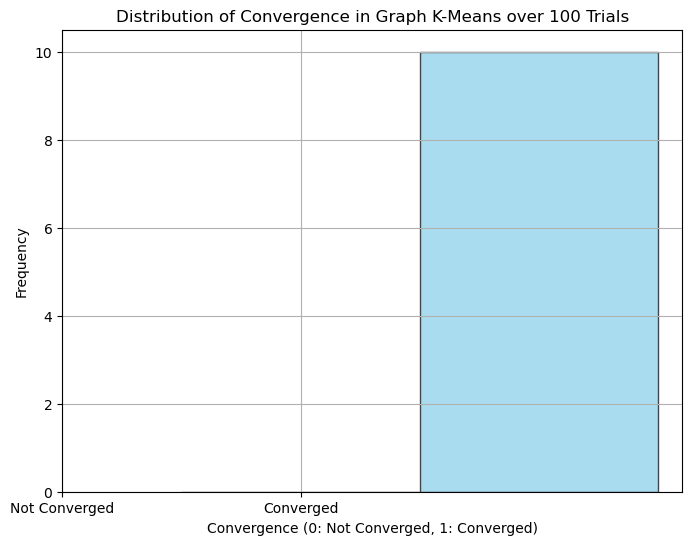

In [17]:
plot_convergence_histogram(converge)

In [18]:
plot_convergence_steps(converge, step)

### Insights

Note: changed scales from 10 to 100, when experimenting this function

Not a lot of model is converged from the model.

Not a good metric to use.

The Goal is to provide a model that 100 percent converges.

Also the minunimum steps to Converge is varies from 3 to 8. The goal is have a more accuracte representation for the model to converge, like one value at 4 or 5. We should try to find.

# 1.  Variations Exploration

Yes, there is  alternatives for the shortest distance on ghraphs, as we can use betweenness, eigenvector, and degree.

## The betweenness measure

The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!


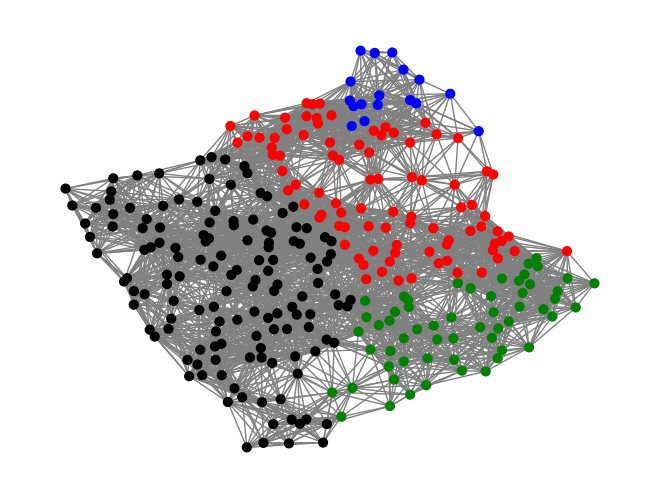

1

<Figure size 640x480 with 0 Axes>

In [19]:
G = nx.random_geometric_graph(300, .2)

graph_k_means = GraphKMeans(G,
                            k=4,
                            n_iter=10,
                            centrality_measure='betweenness')
d = graph_k_means.fit()

draw = graph_parition_plot(G, d)
draw.draw_graph_partition()

### Plot Insights:
Based on the plot, the Algorithm seems to converges as the edges seem to be correctly placed. We can that the red cluster seems smallest cluster. There looks to be outliers in the black cluster.

In [20]:
G = nx.random_geometric_graph(100, .2)
times = running_time(G,
                     4,
                     n_iter=50,
                     initialization='random',
                     centrality_measure='betweenness')
print("Running time: ", times)

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
Running time:  0.20860862731933594


In [21]:
running_times = basic_run_time(G,
                               k,
                               n_iter=50,
                               centrality_measure='pagerank',
                               num_iterations=1)

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!


In [22]:
running_times = basic_run_time(G, k,
                               n_iter=50,
                               initialization='random',
                               centrality_measure='betweenness',
                               num_iterations=10)

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges 

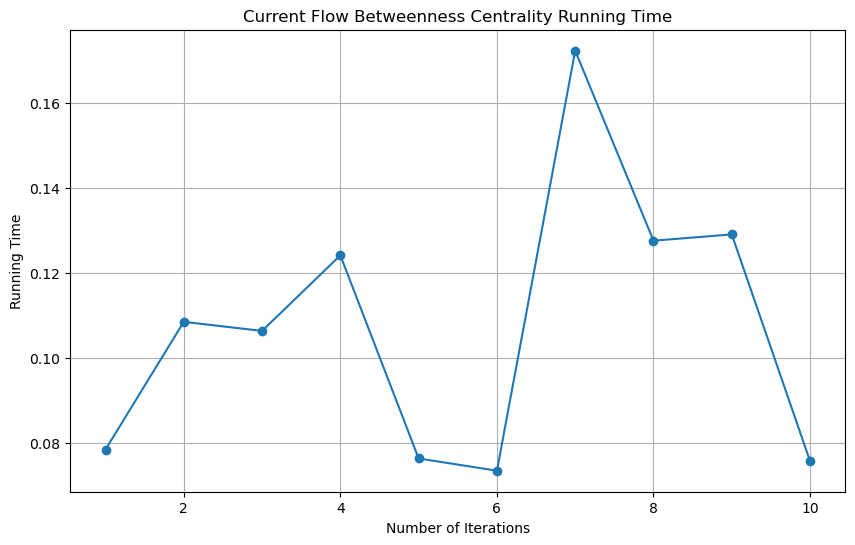

In [23]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), running_times, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('Running Time')
plt.title('Current Flow Betweenness Centrality Running Time')
plt.grid(True)
plt.show()

### Comment
Seems to be slower for betweenness, as it either goes from .08 to .16,  as the algorithm does converge mostly.

In [24]:
converge, step = run_kmeans_trials(G,
                                   num_trials=10,
                                   k=4,
                                   n_iter=10,
                                   initialization='random',
                                   centrality_measure="betweenness")

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges 

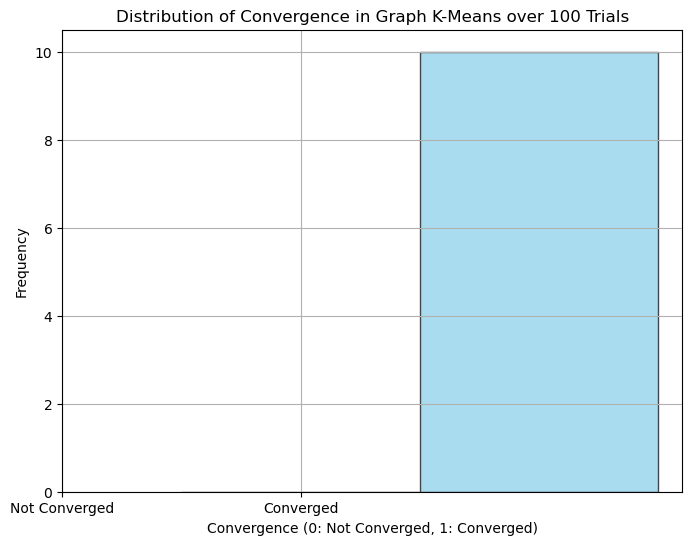

In [25]:
plot_convergence_histogram(converge)

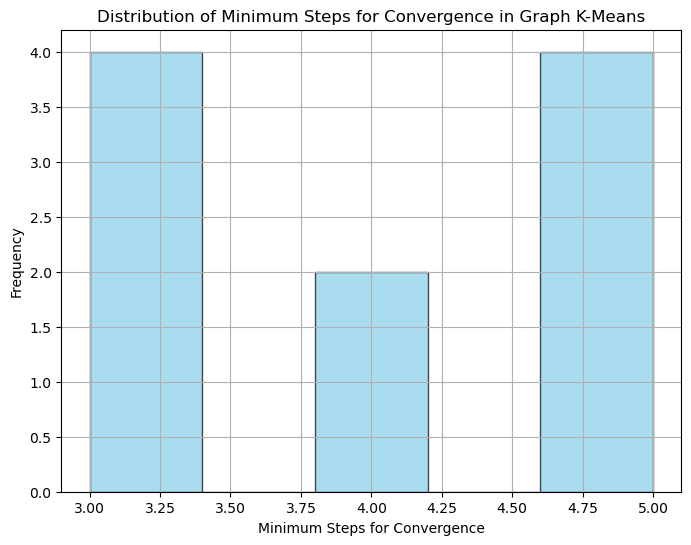

In [26]:
plot_convergence_steps(converge, step)

## Insights

Note: changed scales from 10 to 100, when experimenting this function

Betweeness does well in converging all 10 to 100 trials, while there seem to be a spread out distribution with mininum convergence from 3-8. We want to find a more central miniunum convergence step.

## Eigenvector measure

The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!


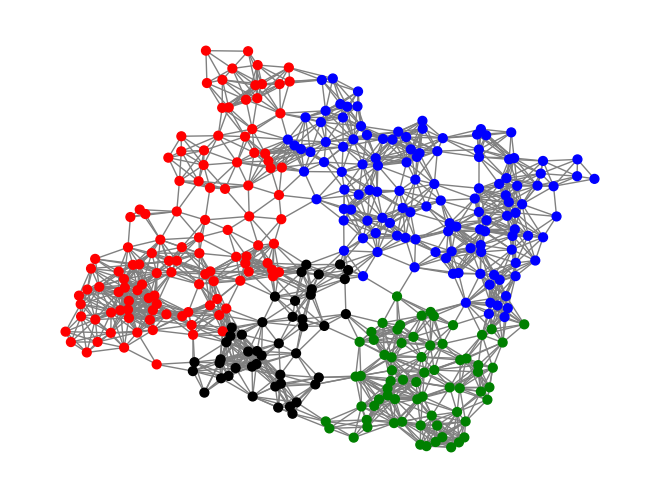

1

<Figure size 640x480 with 0 Axes>

In [27]:
G = nx.random_geometric_graph(350, 0.115)

graph_k_means = GraphKMeans(G,
                            k=4,
                            n_iter=10,
                            centrality_measure='eigenvector')
d = graph_k_means.fit()

draw = graph_parition_plot(G, d)
draw.draw_graph_partition()

In [28]:
G = nx.random_geometric_graph(200, 0.2)
running_time(G,
             4,
             n_iter=50,
             initialization='random',
             centrality_measure='eigenvector')
print("Running time: ", times)

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
Running time:  0.20860862731933594


In [29]:
running_times = basic_run_time(G,
                               k,
                               n_iter=50,
                               initialization='random',
                               centrality_measure='pagerank',
                               num_iterations=1)

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!


In [30]:
running_times = basic_run_time(G, k,
                               n_iter=50,
                               initialization='random',
                               centrality_measure='eigenvector',
                               num_iterations=10)

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Algorithm converges with 6 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Do

In [31]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), running_times, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('The Running Time')
plt.title('Eigenvector Running Time')
plt.grid(True)
plt.show()

### Comment
Seems to be faster than the base model as it is around .6 to 1.8. Not a good model to use. Will reduce 100 to 10, since I will do less experimentation for this model, since the run time is bad.

In [32]:
G = nx.random_geometric_graph(200, 0.2)
converge, step = run_kmeans_trials(G,
                                   num_trials=10,
                                   k=4,
                                   n_iter=50,
                                   initialization='random',
                                   centrality_measure="eigenvector")

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Algorithm converges with 8 steps.
Done!
The graph nodes have been relabel

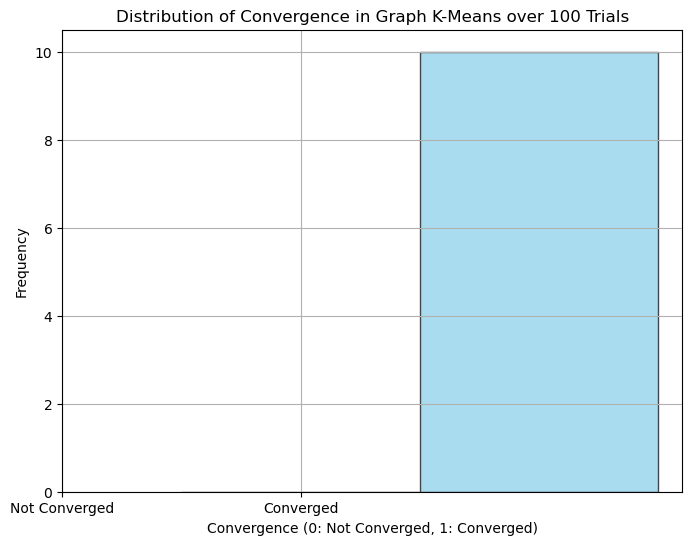

In [33]:
plot_convergence_histogram(converge)

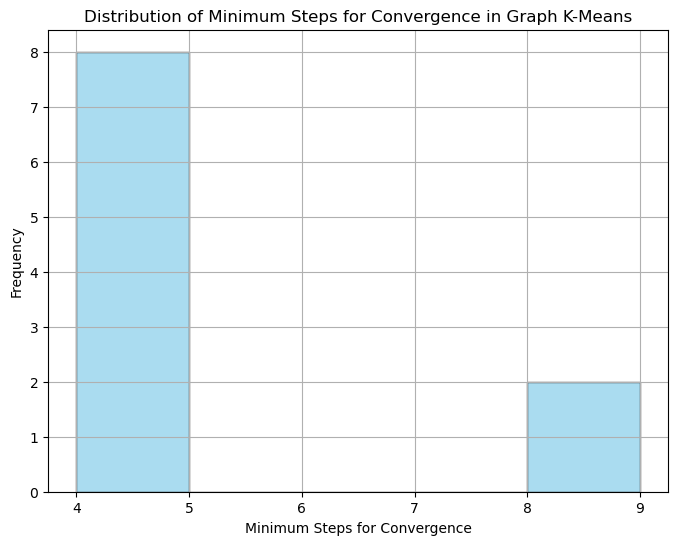

In [34]:
plot_convergence_steps(converge, step)

### Insights

Note changed from 100 to 10, since it took so lon to converge. Not a good model to use for Experiment.

We can see the model converges for all 100 for Eigenvector, while there is more mininum steps from 3 to 11. Our goal is to find the shortest and most accurate minunium steps.

For 10 steps, most at 4, though ranges from 3 to 7.

## The degree measure

In [35]:
G = nx.random_geometric_graph(200, 0.2)

graph_k_means = GraphKMeans(G,
                            k=4,
                            n_iter=10,
                            centrality_measure='degree')
d = graph_k_means.fit()


draw = graph_parition_plot(G, d)
draw.draw_graph_partition()

The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!


1

<Figure size 640x480 with 0 Axes>

In [36]:
times = running_time(G,
                     4,
                     n_iter=50,
                     initialization='random',
                     centrality_measure='degree')
print("Running time: ", times)

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
Running time:  0.009273052215576172


In [37]:
running_times = basic_run_time(G, k,
                               n_iter=50,
                               initialization='random',
                               centrality_measure='degree',
                               num_iterations=10)

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Do

In [38]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), running_times, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('Running Time')
plt.title('Degree Running Time')
plt.grid(True)
plt.show()

### Comment
Seems to be faster than the base model as it is around .01 seconds.

In [39]:
converge, step = run_kmeans_trials(G,
                                   num_trials=100,
                                   k=4,
                                   n_iter=10,
                                   initialization='random',
                                   centrality_measure="degree")

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Algorithm converges with 6 steps.
Done!
The graph nodes have been relabel

Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers

Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!


In [40]:
plot_convergence_histogram(converge)

In [41]:
plot_convergence_steps(converge, step)

## Insights
The largest minumum steps is at 4, though their is distrubution of steps converged from 3 to 9. Telling me that it has not converged well yet.

# Current_flow_betweenness_centrality

In [42]:
G = nx.random_geometric_graph(200, 0.2)
measure = all_measures["current_flow_betweenness_centrality"]
print("Running time: ", measure["running_time"])

Running time:  1.7969961166381836


In [43]:
running_times = basic_run_time(G, k,
                               n_iter=50,
                               centrality_measure='current_'
                               'flow_betweenness_centrality',
                               num_iterations=10)

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Algorithm converges with 6 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Algorithm converges with 6 steps.
Done!
The graph nodes have been relabeled to integers.
Do

In [44]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), running_times, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('The Running Time')
plt.title('Current Flow Betweenness Centrality Running Time')
plt.grid(True)
plt.show()

### Insights

Here we can see it can reach above 1 second. This model does not perform better than the base mode which is around .2 to .3 seconds. Will 

In [45]:
converge, step = run_kmeans_trials(G,
                                   num_trials=10,
                                   k=4,
                                   n_iter=10,
                                   initialization='random',
                                   centrality_measure="current_flow_"
                                   "betweenness_centrality")

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Do

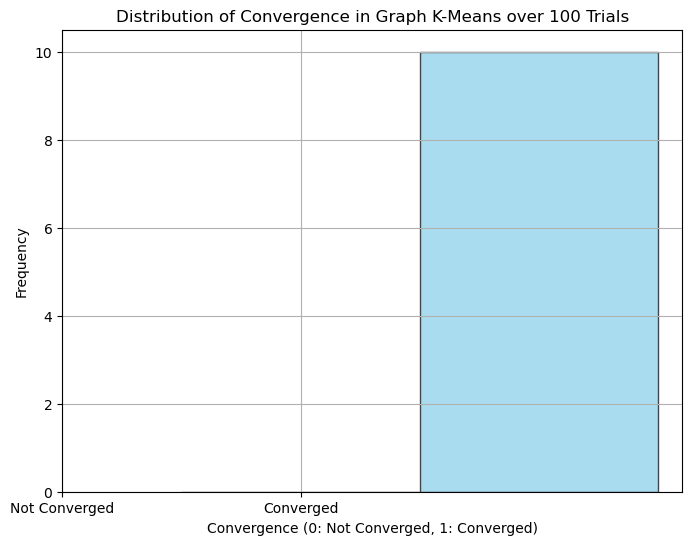

In [46]:
plot_convergence_histogram(converge)

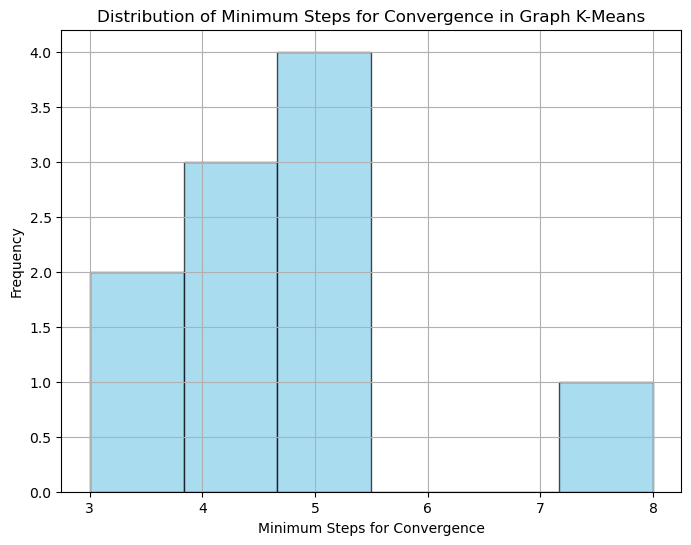

In [47]:
plot_convergence_steps(converge, step)

## Insights
We can see that all converged well, while the mininum steps are still spread out. Our goal is to have the smallest mininum step, while having a more central answer.

# Current_flow_betweenness_centrality_subset

In [48]:
measure = all_measures["current_flow_betweenness_centrality_subset"]
print("Running time: ", measure["running_time"])

Running time:  1.437967300415039


In [49]:
running_times = basic_run_time(G,
                               k,
                               n_iter=50,
                               initialization='random',
                               centrality_measure='current_flow_'
                               'betweenness_centrality_subset',
                               num_iterations=10)

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Algorithm converges with 6 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Do

In [50]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), running_times, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('Running Time')
plt.title('Current Flow Betweenness Centrality Subset Running Time')
plt.grid(True)
plt.show()

## Insights

The running time does not do too well compared to the base model, as it ranges from .6 to 1 seconds. Will not use this model going foreward.

In [51]:
converge, step = run_kmeans_trials(G,
                                   num_trials=10,
                                   k=4,
                                   n_iter=10,
                                   initialization='random',
                                   centrality_measure="current_flow_"
                                   "betweenness_centrality_subset")

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Algorithm converges with 6 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Algorithm converges with 7 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabel

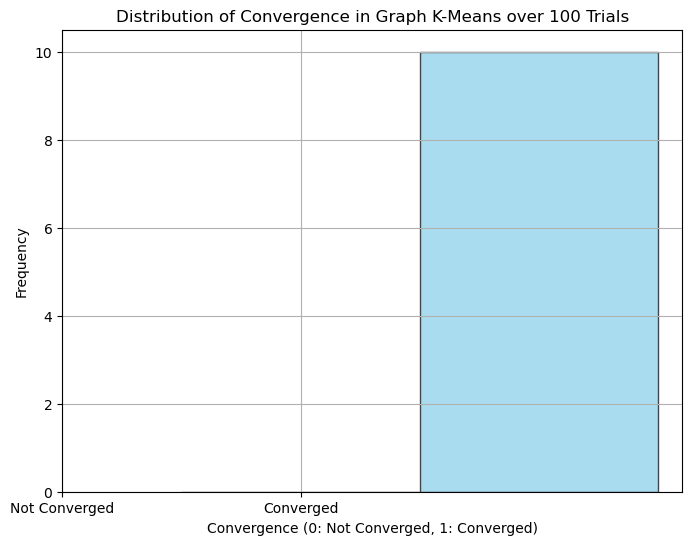

In [52]:
plot_convergence_histogram(converge)

In [53]:
plot_convergence_steps(converge, step)

### Insights

current_flow_betweenness_centrality_subset does converge well at 100 trials, while the miniumn step to converge varies from 3 to 8, showing that this model does not improve from the base model. Will not use this model going forward.

# Current_flow_closeness_centrality

In [54]:
running_times = basic_run_time(G,
                               k,
                               n_iter=50,
                               initialization='random',
                               centrality_measure='current_flow'
                               '_closeness_centrality',
                               num_iterations=10)

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4


/opt/homebrew/anaconda3/lib/python3.11/site-packages/networkx/algorithms/centrality/current_flow_closeness.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])


Doing iteration 5
Doing iteration 6
Algorithm converges with 6 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph n

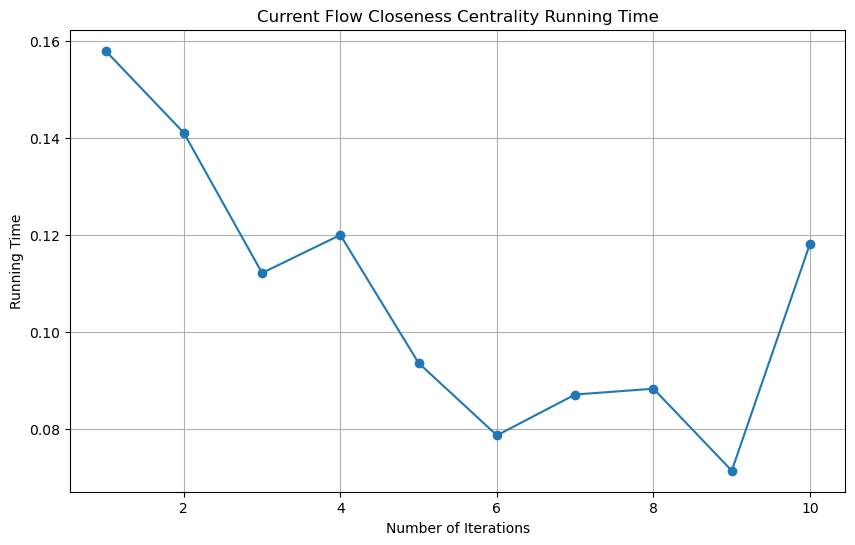

In [55]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), running_times, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('Running Time')
plt.title('Current Flow Closeness Centrality Running Time')
plt.grid(True)
plt.show()

### Insight

This model does slightly worse than the base model, as  it ranges around .1 seconds. So we should do more experimentation.

In [56]:
converge, step = run_kmeans_trials(G,
                                   num_trials=100,
                                   k=4,
                                   n_iter=10,
                                   initialization='random',
                                   centrality_measure="current_flow_"
                                   "closeness_centrality")

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabel

Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Algorithm converges with 7 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Algorithm converges with 8 steps.
Done!
The graph nodes have been relabeled to integer

Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Algorithm converges with 7 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration

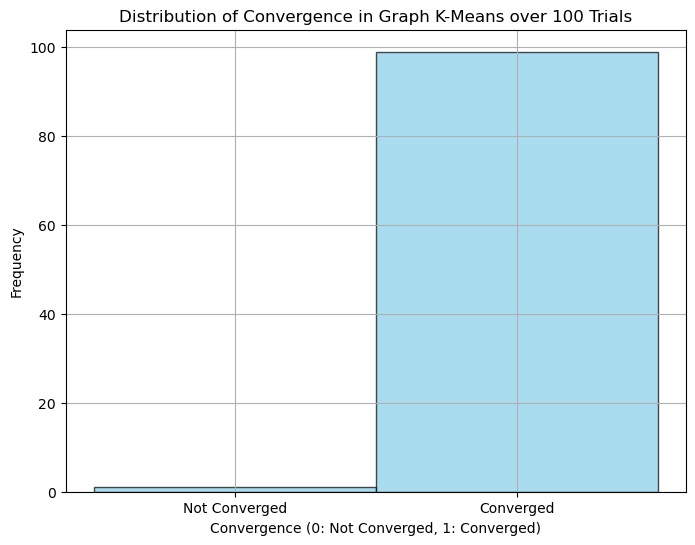

In [57]:
plot_convergence_histogram(converge)

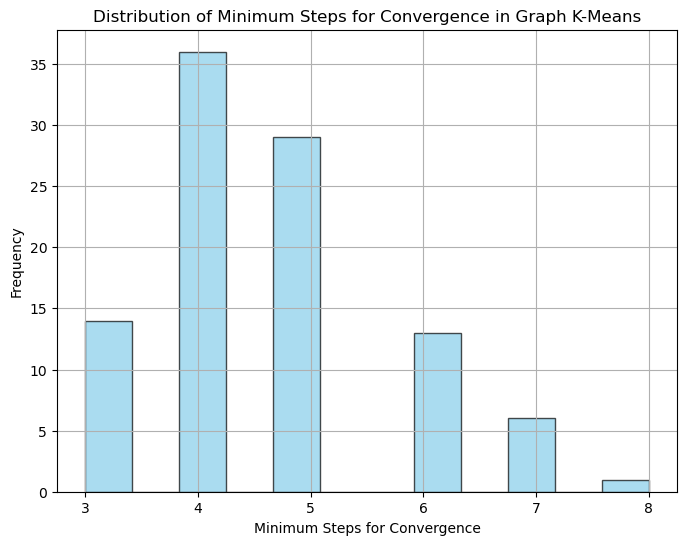

In [58]:
plot_convergence_steps(converge, step)

### Insights

Some minor values do not converge with this model, and like before, the miniunu step converges from a distribution of 3 to 8 or 9

### Approximate_current_flow_betweenness_centrality

In [59]:
G = nx.random_geometric_graph(200, 0.2)

running_times = running_time(G,
                             2, n_iter=50,
                             initialization='random',
                             centrality_measure='approximate_'
                             'current_flow_betweenness_centrality',
                             num_iterations=1)
running_times

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Algorithm converges with 8 steps.
Done!


0.7906560897827148

This will compute the centrality scores for every node in the graph using this approximation method.Then we use those scores to select the initial cluster centers

###  Insights

Based on the previous experiments, it is evident that this process takes a significant amount of time to complete. Our objective is to achieve a running time of less than 0.3 seconds

The model does not work with smaller graph, and radiuses, so it likely will take a long time to run. Will not use this measure any further. As shown above the run time is greater 1 second.

# Information_centrality

In [60]:
running_times = basic_run_time(G,
                               k,
                               n_iter=50,
                               initialization='random',
                               centrality_measure='information_centrality',
                               num_iterations=10)

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Algorithm converges with 8 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Algorithm converges with 6 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
A

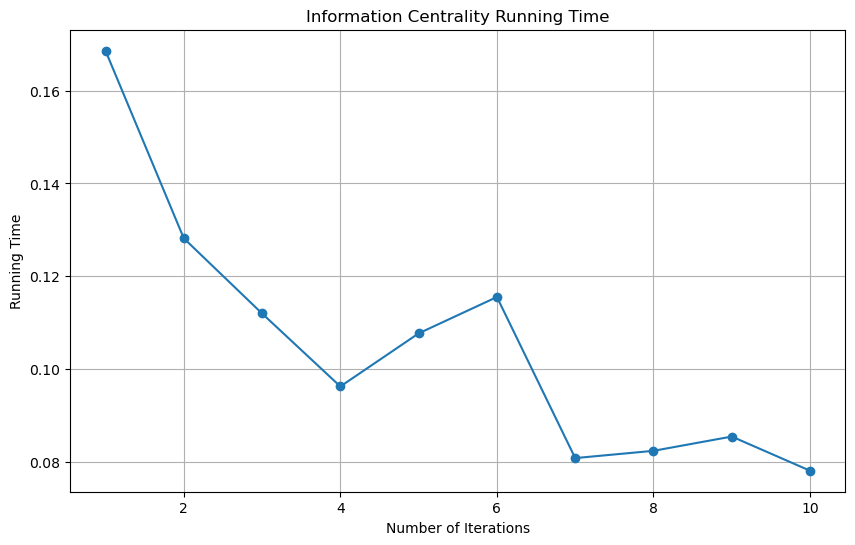

In [61]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), running_times, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('Running Time')
plt.title('Information Centrality Running Time')
plt.grid(True)
plt.show()

### Insights

information_centrality does not do well compared the base model of page rank which is above .1 to .2 seconds. As the goal is to reduce the running time.

In [62]:
converge, step = run_kmeans_trials(G,
                                   num_trials=10,
                                   k=4,
                                   n_iter=10,
                                   initialization='random',
                                   centrality_measure="information_centrality")

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Algorithm converges with 8 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Algorithm converges

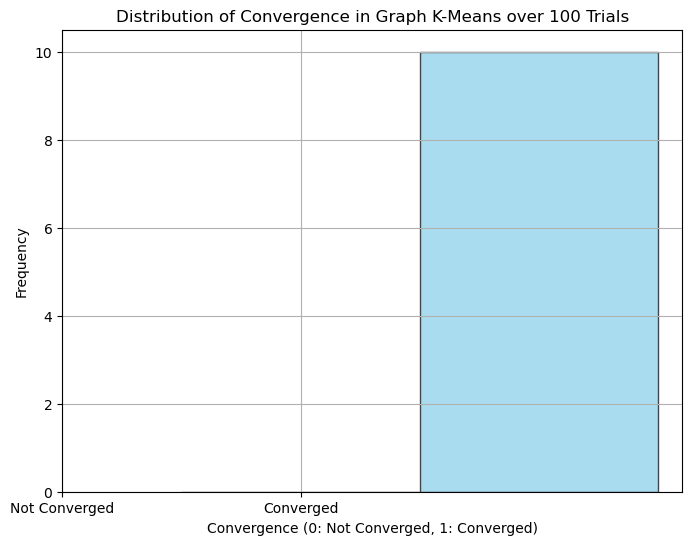

In [63]:
plot_convergence_histogram(converge)

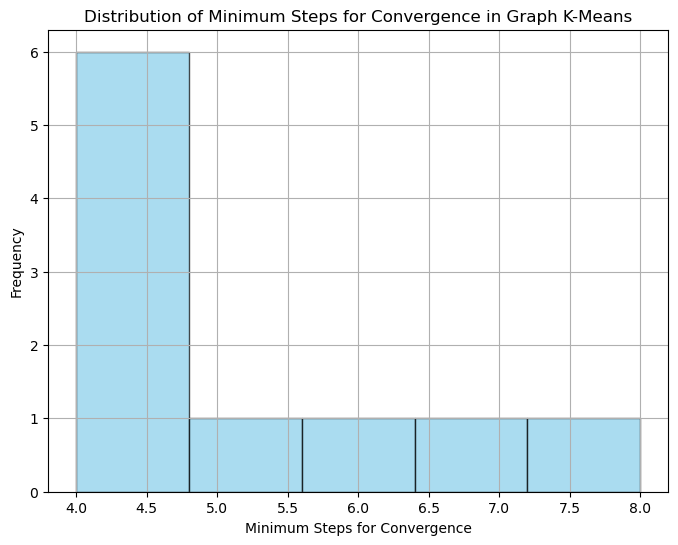

In [64]:
plot_convergence_steps(converge, step)

### Insights

Note: changed scales from 10 to 100, when experimenting this function

Based on the Effenciecy, we see that the model converges for all 10 to 100 trials and  the mininum steps is still a distribution of values from  3 to 8.

# Percolation_centrality

In [65]:
measure = all_measures["percolation_centrality"]
print("Running time: ", measure["running_time"])

Running time:  1.3756978511810303


## Insights

percolation Centrality does not do well compared to page rank as the time take more than a second. As it is close to a second.

Therfore we will not need to do further experimentation.

# Subgraph_centrality

In [66]:
measure = all_measures["subgraph_centrality"]
print("Running time: ", measure["running_time"])

Running time:  0.06108689308166504


In [67]:
running_times = basic_run_time(G,
                               k,
                               n_iter=50,
                               initialization='random',
                               centrality_measure='subgraph_centrality',
                               num_iterations=10)

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Do

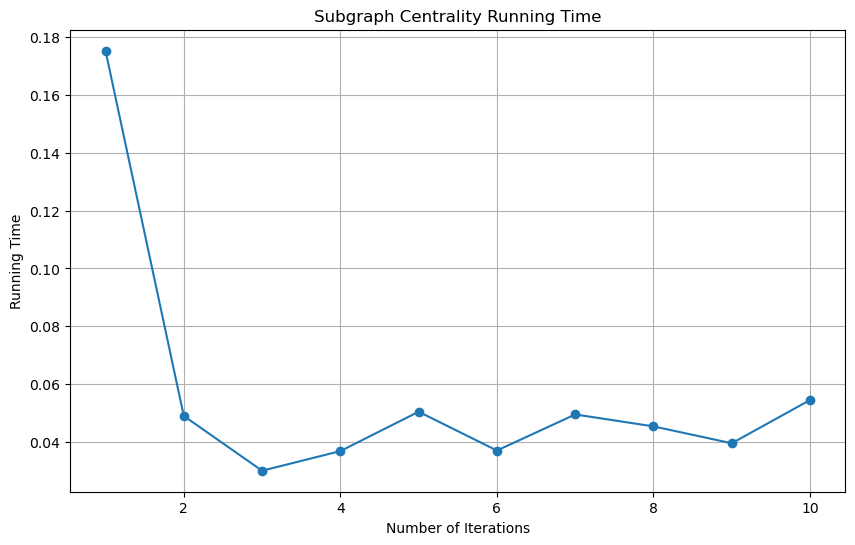

In [68]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), running_times, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('Running Time')
plt.title('Subgraph Centrality Running Time')
plt.grid(True)
plt.show()

### Insights

This model does slightly worse than page rank as its running time is around .02 to .04.

In [69]:
converge, step = run_kmeans_trials(G,
                                   num_trials=10,
                                   k=4,
                                   n_iter=10,
                                   initialization='random',
                                   centrality_measure="subgraph_centrality")

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Algorithm converges with 7 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Do

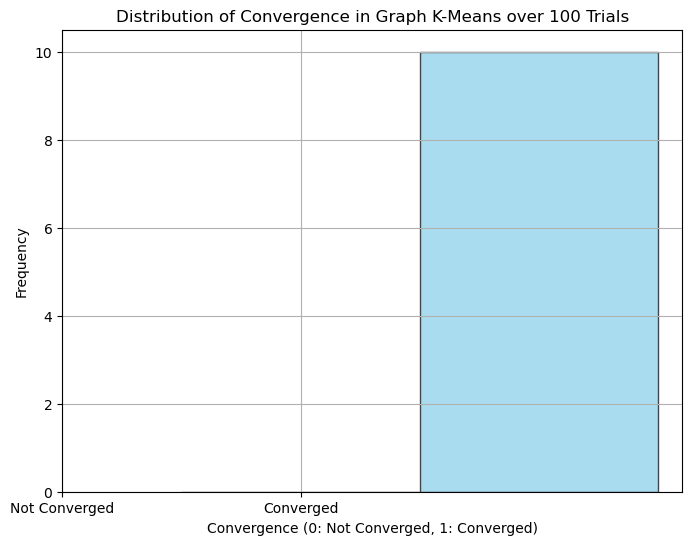

In [70]:
plot_convergence_histogram(converge)

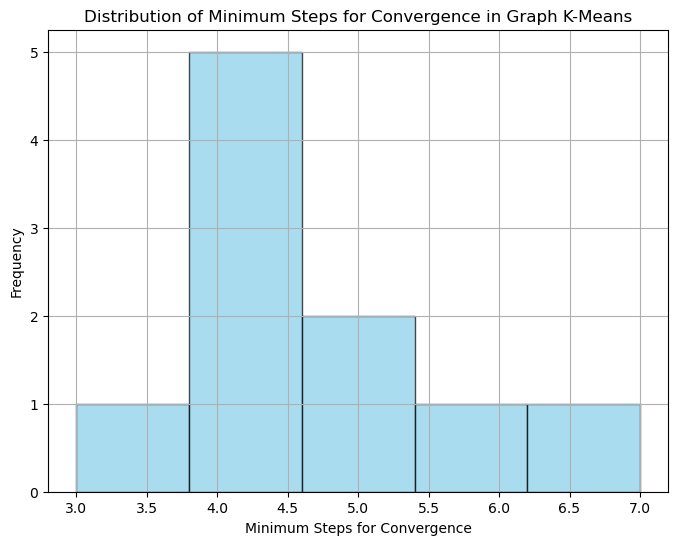

In [71]:
plot_convergence_steps(converge, step)

### Insights 

Note: changed scales from 10 to 100, when experimenting this function.

The model seems to not converge within 10 to 100 iterations, while the mininum steps for convergence is from 3 to 5.

There is some that do not converge, so not a good measure.

# Subgraph_centrality_exp

In [72]:
measure = all_measures["subgraph_centrality_exp"]
print("Running time: ", measure["running_time"])

Running time:  0.25763511657714844


In [73]:
running_times = basic_run_time(G,
                               k,
                               n_iter=50,
                               initialization='random',
                               centrality_measure='subgraph_centrality_exp',
                               num_iterations=10)

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabel

In [74]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), running_times, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('Running Time')
plt.title('Subgraph Centrality Exp Running Time')
plt.grid(True)
plt.show()

## insights

The running time is around .05 to .25, which is slightly worse than page rank model.

In [75]:
converge, step = run_kmeans_trials(G,
                                   num_trials=100,
                                   k=4,
                                   n_iter=10,
                                   initialization='random',
                                   centrality_measure="subgraph_"
                                   "centrality_exp")

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Algorithm converges with 6 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Do

Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Algorithm converges with 7 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration

Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration

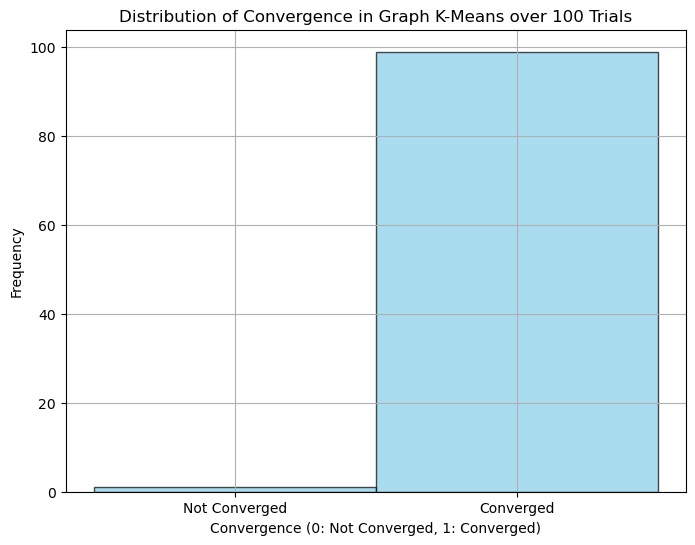

In [76]:
plot_convergence_histogram(converge)

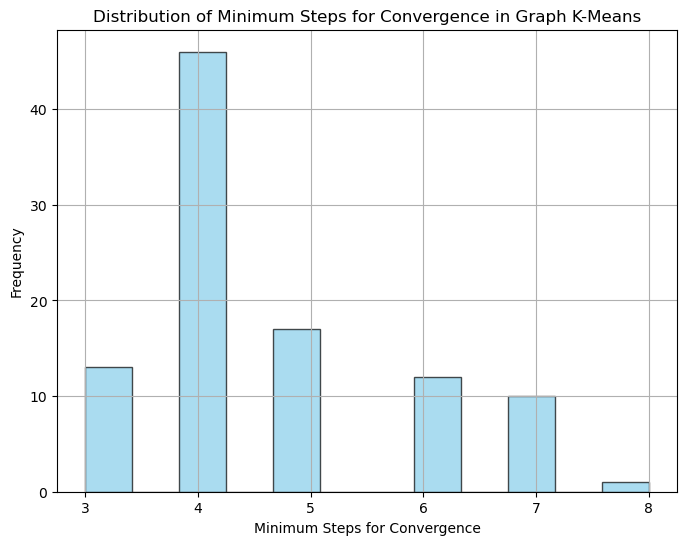

In [77]:
plot_convergence_steps(converge, step)

### Insights

We see this model converges well within 100 trials, while distribution apears to be from 3 to 8 miniunm steps. Will need more experimentation.

# Second_order_centrality

### Sample Code

G = nx.random_geometric_graph(300, 0.2)

running_times = running_time(G,
                             4,
                             n_iter=10,
                             initialization='random',
                             centrality_measure='second_order_centrality',
                             num_iterations=1)
running_times

### This code take a long time to run:

### Insights

Since the above code takes a long time to converge, so not a good model to use.

Second order centrality consideres the nodes among it neighbors as it provides structural support among the neighbors.

Like from previous experimentations, we see that second_order_centrality is not a good measure, as its run time takes a long time to run.

The sample code takes a considerable amount of time to execute at .75, while needed is around .2, ranging from 2 to 7 seconds for higher graphs. However, there is no notable improvement observed compared to using PageRank centrality. Therefore, we have decided not to conduct further testing on this model.

# Load_centrality

In [78]:
measure = all_measures["load_centrality"]
print("Running time: ", measure["running_time"])

Running time:  1.4299428462982178


In [79]:
G = nx.random_geometric_graph(200, 0.2)
running_times = basic_run_time(G,
                               k,
                               n_iter=10,
                               initialization='random',
                               centrality_measure='load_centrality',
                               num_iterations=10)

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Doing iteration 9
Algorithm did not converge
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The 

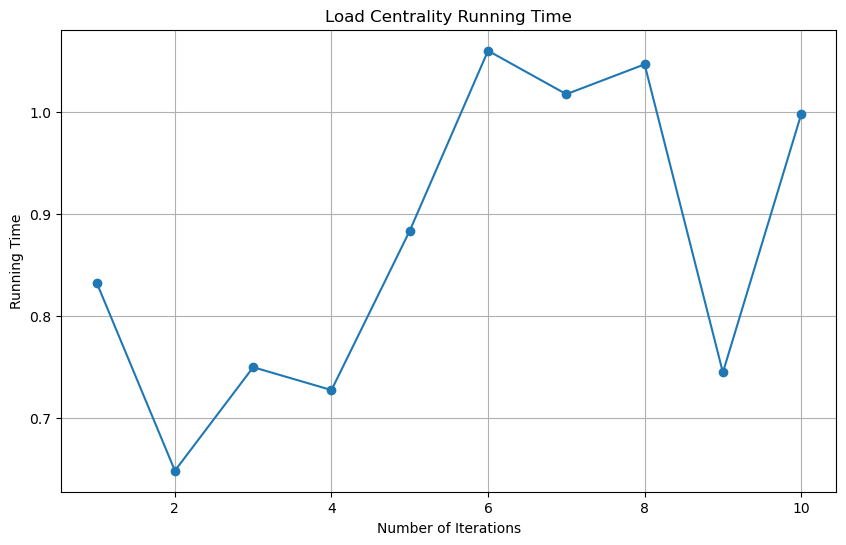

In [80]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), running_times, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('Running Time')
plt.title('Load Centrality Running Time')
plt.grid(True)
plt.show()

## Insights

This model is above  above .6 seconds, as the model does not improve in ruuning time.

In [81]:
converge, step = run_kmeans_trials(G,
                                   num_trials=10,
                                   k=4,
                                   n_iter=10,
                                   initialization='random',
                                   centrality_measure="load_centrality")

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Algorithm converges with 6 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Algorithm converges with 7 steps.
Done!
The graph nodes have been relabeled to integers.
Do

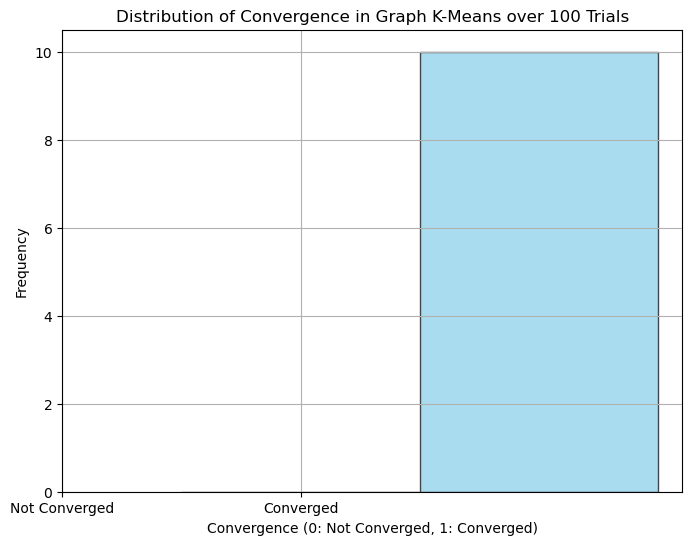

In [82]:
plot_convergence_histogram(converge)

In [83]:
plot_convergence_steps(converge, step)

### Insights

The mininunum steps for convergence ranges from 3 to 6. As the model converges within 10 to 100 iterations.

Note: changed scales from 10 to 100, when experimenting this function.

# Closeness Centrality

In [84]:
measure = all_measures["closeness_centrality"]
print("Running time: ", measure["running_time"])

Running time:  0.2613379955291748


In [85]:
running_times = basic_run_time(G,
                               k,
                               n_iter=10,
                               initialization='random',
                               centrality_measure='closeness_centrality',
                               num_iterations=10)

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Algorithm converges with 7 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Do

In [86]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), running_times, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('Run Time')
plt.title('Closeness Centrality Running Time')
plt.grid(True)
plt.show()

## Insights

Takes more time than the page rank model. As it border .4. This is clearly not a good metric to use.

In [87]:
converge, step = run_kmeans_trials(G,
                                   num_trials=10,
                                   k=4,
                                   n_iter=10,
                                   initialization='random',
                                   centrality_measure="closeness_centrality")

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Algorithm converges with 7 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Do

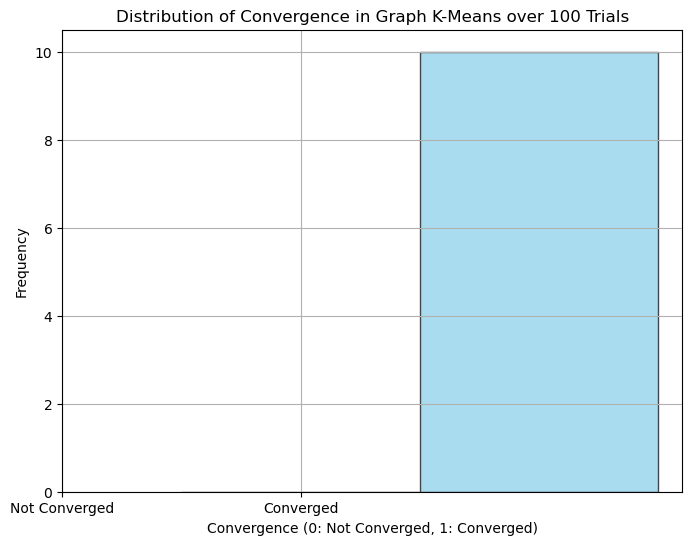

In [88]:
plot_convergence_histogram(converge)

In [89]:
plot_convergence_steps(converge, step)

### Insights

Note: changed scales from 10 to 100, when experimenting this function

This shows that some models do not converge for 10 to 100 iterations. While the mininum steps for convergence ranges from 3 to 6. 

# Harmonic_centrality

In [90]:
measure = all_measures["harmonic_centrality"]
print("Running time: ", measure["running_time"])

Running time:  0.5625951290130615


In [91]:
running_times = basic_run_time(G, k,
                               n_iter=50,
                               initialization='random',
                               centrality_measure='harmonic_centrality',
                               num_iterations=10)

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Algorithm converges with 7 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Algorithm converges with 6 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes

In [92]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), running_times, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('Run time (s)')
plt.title('harmonic Centrality Running Time')
plt.grid(True)
plt.show()

### Insight

All of these run times are higher compared to the base model. May not be the best model to compare with page rank.


In [93]:
converge, step = run_kmeans_trials(G,
                                   num_trials=10,
                                   k=4,
                                   n_iter=10,
                                   initialization='random',
                                   centrality_measure="harmonic_centrality")

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Algorithm converges with 6 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Do

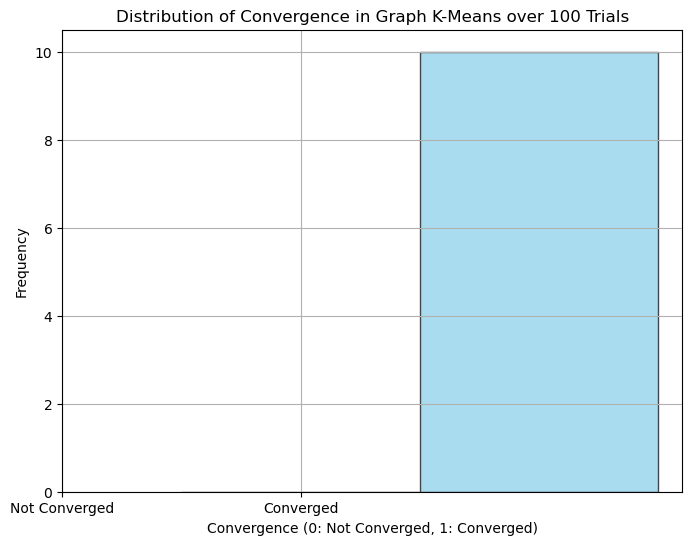

In [94]:
plot_convergence_histogram(converge)

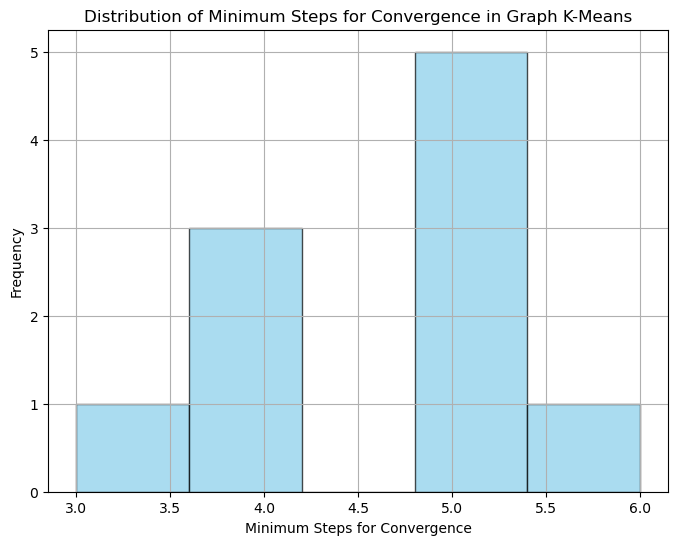

In [95]:
plot_convergence_steps(converge, step)

### Insights
We can see that the model converges, while the miniunim steps for convergence does not do well as it ranges from 3 to 6.

# 2.  Initialization Algorithms

# K-means ++ initialization

In [96]:
G = nx.random_geometric_graph(350, 0.115)


graph_k_means = GraphKMeans(G, k=4, n_iter=10, initialization='kmeans++')
d = graph_k_means.fit()

draw = graph_parition_plot(G, d)
draw.draw_graph_partition()

The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!


1

<Figure size 640x480 with 0 Axes>

In [97]:
times = running_time(G,
                     4,
                     n_iter=10,
                     centrality_measure='pagerank',
                     num_iterations=1)
print("Running time: ", times)

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
Running time:  0.0332951545715332


In [98]:
times = running_time(G,
                     4,
                     n_iter=10,
                     initialization='kmeans++',
                     centrality_measure='pagerank',
                     num_iterations=1)
print("Running time: ", times)

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
Running time:  0.04157209396362305


### Insights 

We can see that model slightly does worse with k-means++ as the run time is around .4.

In [99]:
converge, step = run_kmeans_trials(G,
                                   num_trials=10,
                                   k=4,
                                   n_iter=10,
                                   initialization='kmeans++',
                                   centrality_measure="pagerank")

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Do

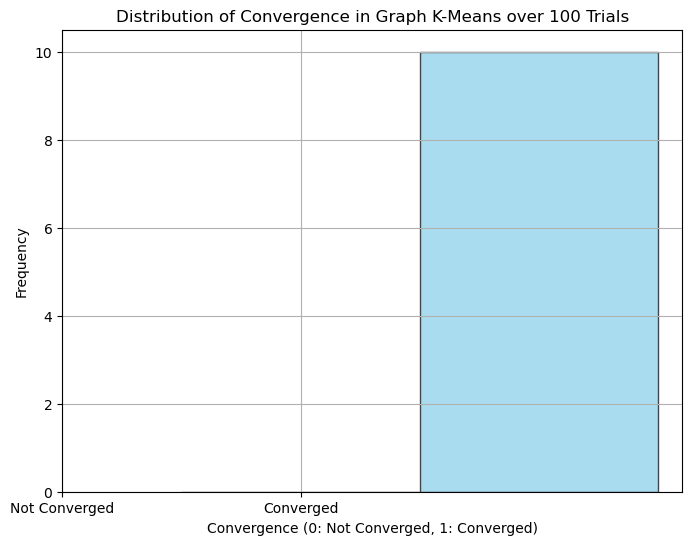

In [100]:
plot_convergence_histogram(converge)

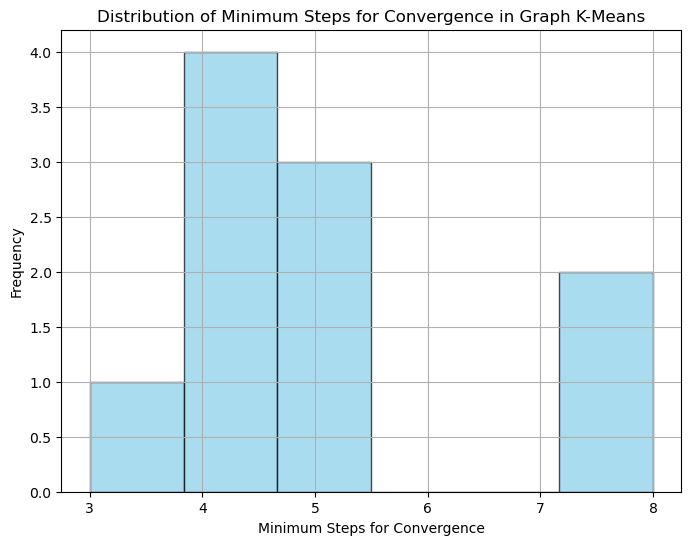

In [101]:
plot_convergence_steps(converge, step)

## Insights

It seems the page rank does not converge within 100 trials. As k-means++ does does factor with convergence and steps.

### Comment

This takes a almost smaller running time than random intialization.

## betweenness initialization

The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Algorithm converges with 2 steps.
Done!


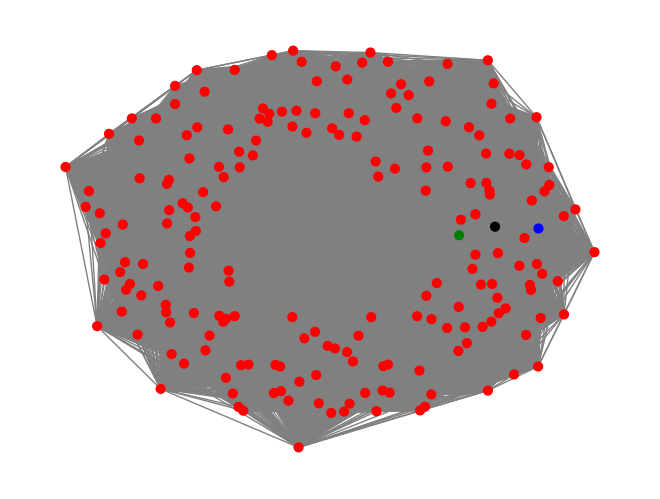

1

<Figure size 640x480 with 0 Axes>

In [102]:
G = nx.random_geometric_graph(200, 2)

graph_k_means = GraphKMeans(G,
                            k=4,
                            n_iter=10,
                            initialization='betweenness')
d = graph_k_means.fit()

draw = graph_parition_plot(G, d)
draw.draw_graph_partition()

In [103]:
times = running_time(G,
                     4,
                     n_iter=50,
                     initialization='betweenness',
                     centrality_measure='pagerank',
                     num_iterations=1)
print("Running time: ", times)

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
Running time:  0.17664122581481934


### Insights:

Some of graph's visualizations does not look that great as shown here.

This takes longer running time than random intialization. So Going forward, I will not use this model.

Will not continue to experiment with the test.

# Degree initialization

The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!


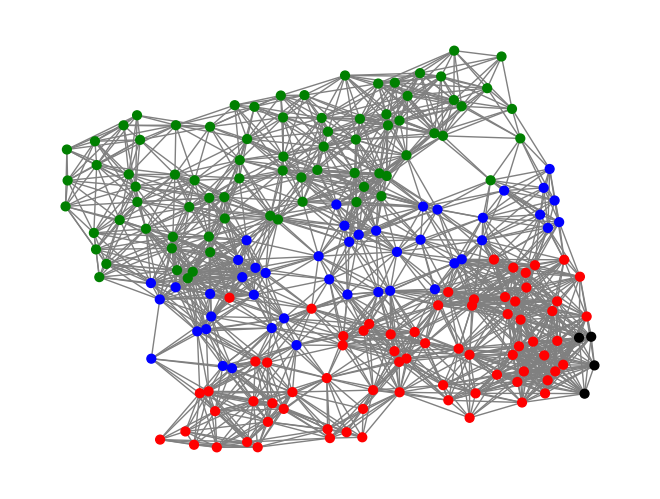

1

<Figure size 640x480 with 0 Axes>

In [104]:
G = nx.random_geometric_graph(200, 0.2)


graph_k_means = GraphKMeans(G,
                            k=4,
                            n_iter=10,
                            initialization='degree')
d = graph_k_means.fit()

draw = graph_parition_plot(G, d)
draw.draw_graph_partition()

### Insights

Some clusters overlap as we look at the chart.

In [105]:
G = nx.random_geometric_graph(200, 0.2)
times = running_time(G,
                     4,
                     n_iter=50,
                     initialization='degree',
                     centrality_measure='pagerank',
                     num_iterations=1)
print("Running time: ", times)

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Doing iteration 9
Doing iteration 10
Doing iteration 11
Doing iteration 12
Doing iteration 13
Doing iteration 14
Doing iteration 15
Doing iteration 16
Doing iteration 17
Doing iteration 18
Doing iteration 19
Doing iteration 20
Doing iteration 21
Doing iteration 22
Doing iteration 23
Doing iteration 24
Doing iteration 25
Doing iteration 26
Doing iteration 27
Doing iteration 28
Doing iteration 29
Doing iteration 30
Doing iteration 31
Doing iteration 32
Doing iteration 33
Doing iteration 34
Doing iteration 35
Doing iteration 36
Doing iteration 37
Doing iteration 38
Doing iteration 39
Doing iteration 40
Doing iteration 41
Doing iteration 42
Doing iteration 43
Doing iteration 44
Doing iteration 45
Doing iteration 46
Doing iteration 47
Doing iteration 48
Doing iteration 49
Algorithm d

### Comment

This takes a almost smaller running time than random intialization. Will Continue to experiment.

In [106]:
running_times = basic_run_time(G,
                               k,
                               n_iter=50,
                               initialization='degree',
                               centrality_measure='pagerank',
                               num_iterations=10)

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Algorithm converges with 6 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Doing iteration 9
D

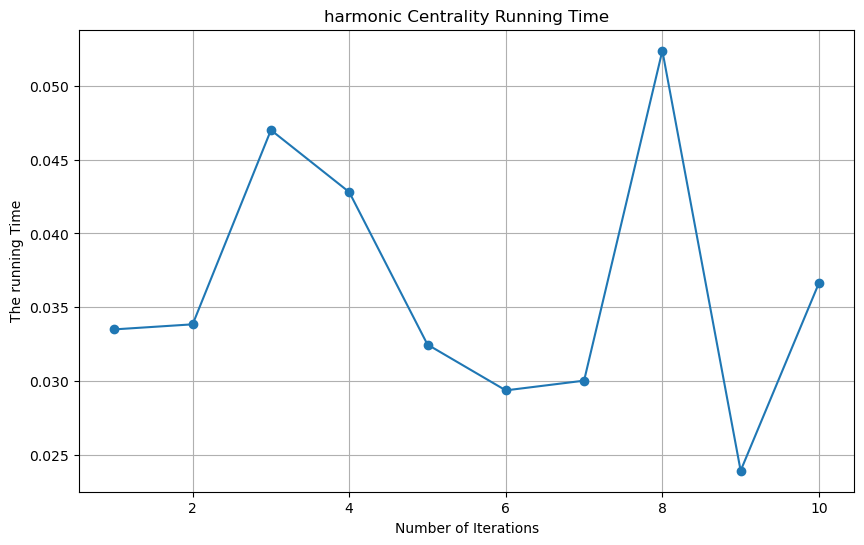

In [107]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), running_times, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('The running Time')
plt.title('harmonic Centrality Running Time')
plt.grid(True)
plt.show()

### Insights

The running time seems to slightly better and slightly worse, as it goes above basline model. This is better for smaller graph sizes. As we see similar times

Will need to look at the graph size for large dataset models.

In [108]:
converge, step = run_kmeans_trials(G,
                                   num_trials=100,
                                   k=4,
                                   n_iter=10,
                                   initialization='degree',
                                   centrality_measure="pagerank")

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Algorithm converges with 6 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Do

Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm conve

Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration

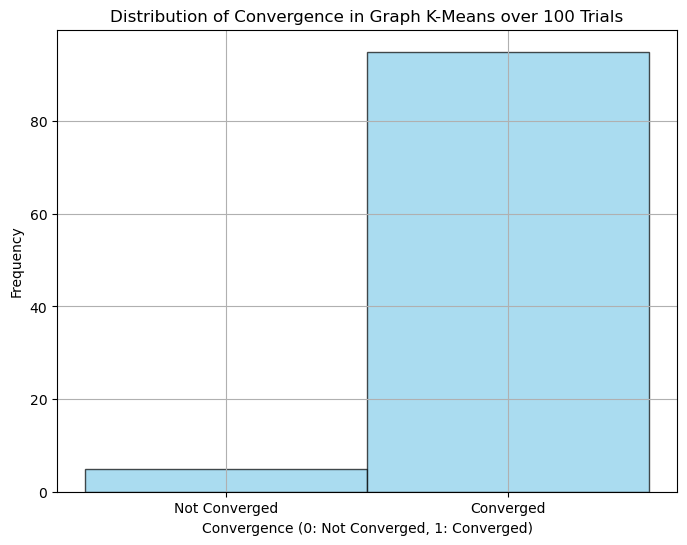

In [109]:
plot_convergence_histogram(converge)

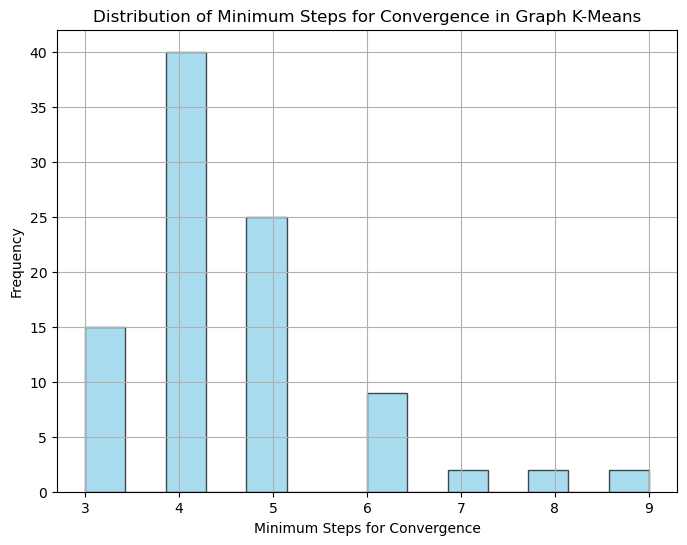

In [110]:
plot_convergence_steps(converge, step)

### Insights

This model converges for at most 100 trials, while the distribution of mininuinum steps for Convergence is around 2 to 8 steps compared to base model.

## Overall Insight: convergence and clustering quality

We observe that using degrees as initialization for the base model is better, as random initialization often fails to converge well, with a higher frequency of cases converging at 3 to 4 clusters compared to random initialization, where convergence occurs across a wider range of minimum steps. Initialization appears to maintain consistent running times across all parameters. However, degrees clustering and k-means++ clustering show good convergence rates, aiming for the minimum number of steps possible.

## 3. Experimental Analysis:

Experimental Analysis: Conduct experimental studies to analyze the running time and efficiency of the base Graph K-Means algorithm. Vary the size and density of input graphs to assess scalability and performance under different conditions.

# Base Graph K-Means Algorithm

In [111]:
def run_experiment():
    """
    Run an experiment to evaluate the performance
    of the Graph K-Means algorithm.

    Generates random geometric graphs
    with various sizes and edge probabilities.
    For each graph, applies the Graph K-Means algorithm
    with a fixed number of clusters and iterations.
    Measures the running time of the algorithm for each experiment.

    Returns:
    --------
    list of tuple:
        A list containing tuples of experiment results.
    """

    graph_sizes = [50, 100, 200, 300, 400, 500]
    edge_probabilities = [0.1, 0.2, .3, .4, 0.5]
    num_clusters = 4
    num_iterations = 10

    results = []

    for size in graph_sizes:
        for edge_prob in edge_probabilities:
            G = nx.random_geometric_graph(size, edge_prob)
            running_times = running_time_base(G,
                                              num_clusters,
                                              num_iterations,
                                              num_iterations=1)
            results.append((size, edge_prob, running_times))

    return results

In [112]:
experiment_results = run_experiment()

The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Hello!
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Hello!
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Hello!
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Hello!
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing

In [113]:
for result in experiment_results:
    print("Graph Size: {},  Radius:"
          "{}, Running Time: {:.6f}"
          "seconds".format(result[0],
                           result[1],
                           result[2]))

Graph Size: 50,  Radius:0.1, Running Time: 0.007472seconds
Graph Size: 50,  Radius:0.2, Running Time: 0.012782seconds
Graph Size: 50,  Radius:0.3, Running Time: 0.016736seconds
Graph Size: 50,  Radius:0.4, Running Time: 0.020235seconds
Graph Size: 50,  Radius:0.5, Running Time: 0.014178seconds
Graph Size: 100,  Radius:0.1, Running Time: 0.018321seconds
Graph Size: 100,  Radius:0.2, Running Time: 0.033984seconds
Graph Size: 100,  Radius:0.3, Running Time: 0.051671seconds
Graph Size: 100,  Radius:0.4, Running Time: 0.062565seconds
Graph Size: 100,  Radius:0.5, Running Time: 0.089757seconds
Graph Size: 200,  Radius:0.1, Running Time: 0.053798seconds
Graph Size: 200,  Radius:0.2, Running Time: 0.142290seconds
Graph Size: 200,  Radius:0.3, Running Time: 0.250055seconds
Graph Size: 200,  Radius:0.4, Running Time: 0.379646seconds
Graph Size: 200,  Radius:0.5, Running Time: 0.482341seconds
Graph Size: 300,  Radius:0.1, Running Time: 0.185727seconds
Graph Size: 300,  Radius:0.2, Running Time: 0

### Insights

For the base model we see that as we increase graph size and radius, the run time increases. We can see that the base model for the graph is increasing. The radius when the graph size are the same, but as we increase radius we see an increase in time.

In [114]:
graph_sizes = {}
for result in experiment_results:
    size = result[0]
    prob = result[1]
    times = result[2]
    if size not in graph_sizes:
        graph_sizes[size] = {'probs': [], 'times': []}
    graph_sizes[size]['probs'].append(prob)
    graph_sizes[size]['times'].append(times)

# Plotting
for size, data in graph_sizes.items():
    plt.plot(data['probs'], data['times'], label=f'Graph Size: {size}')

plt.title('The Running Time for Different Graph Sizes and Edge Probabilities')
plt.xlabel('Edge Probability')
plt.ylabel('Running Time (seconds)')
plt.legend(title='Graph Size')
plt.grid(True)
plt.show()

### Insights

We see an increase in runtime as graph size and radius increases.

## Check the Efficiency!

In [115]:
G = nx.random_geometric_graph(350, 0.115)

converge_list = []
steps_list = []
num_converged = 0
num_not_converged = 0

for i in range(100):
    graph_k_means = GraphKMeansBase(G,
                                    k=4,
                                    n_iter=10)
    d = graph_k_means.fit()
    converge = graph_k_means.converges
    steps = graph_k_means.steps
    steps_list.append(steps)
    converge = 1 if converge else 0
    converge_list.append(converge)

    if converge:
        num_converged += 1
    else:
        num_not_converged += 1

The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Algorithm converges with 6 steps.
Hello!
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Hello!
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Hello!
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Hello!
Done!
The grap

Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Hello!
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Hello!
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Hello!
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Doing iteration 9
Hello!
Algorithm did not converge
Done!
The graph nodes have been relabeled to integers.
Computing the distance 

Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Hello!
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Hello!
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Hello!
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Algorithm converges with 6 steps.
Hello!
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing it

Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Algorithm converges with 6 steps.
Hello!
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Hello!
Done!


In [116]:
plt.figure(figsize=(8, 6))
plt.hist(converge_list, bins=2, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Convergence in Graph K-Means over 100 Trials')
plt.xlabel('Convergence (0: Not Converged, 1: Converged)')
plt.ylabel('Frequency')
plt.xticks([0.25, 0.75], ['Not Converged', 'Converged'])
plt.grid(True)
plt.show()

print("Number of converged trials:", num_converged)
print("Number of non-converged trials:", num_not_converged)

Number of converged trials: 91
Number of non-converged trials: 9


In [117]:
converged_steps = [steps_list[i] for i in range(100)
                   if converge_list[i] == 1]
plt.figure(figsize=(8, 6))
plt.hist(converged_steps,
         bins='auto',
         color='skyblue',
         edgecolor='black',
         alpha=0.7)
plt.title('Distribution of Minimum Steps'
          'for Convergence in Graph K-Means')
plt.xlabel('Minimum Steps for Convergence')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

##  My Models Graph K-Means Algorithm with Random and Pagerank.

### Running Time

In [118]:
def run_experiment():
    """
    Run an experiment to evaluate the performance
    of the Graph K-Means algorithm.

    Generates random geometric graphs
    with various sizes and edge probabilities.
    For each graph, applies the Graph K-Means algorithm
    with a fixed number of clusters and iterations.
    Measures the running time of the algorithm for each experiment.

    Returns:
    --------
    list of tuple:
        A list containing tuples of experiment results.
    """

    graph_sizes = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900]
    edge_probabilities = [0.1, 0.2, .3, .4, 0.5, .6, .7, .8, .9]
    num_clusters = 4
    num_iterations = 10

    results = []

    for size in graph_sizes:
        for edge_prob in edge_probabilities:
            print(size, edge_prob)
            print("-"*100)
            G = nx.random_geometric_graph(size, edge_prob)
            running_times = running_time(G,
                                         num_clusters,
                                         num_iterations,
                                         num_iterations=1)
            results.append((size, edge_prob, running_times))

    return results

In [119]:
experiment_results = run_experiment()

50 0.1
----------------------------------------------------------------------------------------------------
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Doing iteration 9
Algorithm did not converge
Done!
50 0.2
----------------------------------------------------------------------------------------------------
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
50 0.3
----------------------------------------------------------------------------------------------------
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iterat

Doing iteration 3
Algorithm converges with 3 steps.
Done!
300 0.1
----------------------------------------------------------------------------------------------------
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Algorithm converges with 7 steps.
Done!
300 0.2
----------------------------------------------------------------------------------------------------
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Doing iteration 9
Algorithm did not converge
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
300 0.3
------------------------------------------

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
500 0.6
----------------------------------------------------------------------------------------------------
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
500 0.7
----------------------------------------------------------------------------------------------------
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
500 0.8
----------------------------------------------------------------------------------------------------
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
500 0.9
---

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
800 0.6
----------------------------------------------------------------------------------------------------
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
800 0.7
----------------------------------------------------------------------------------------------------
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
800 0.8
----------------------------------------------------------------------------------------------------
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration

In [120]:
for result in experiment_results:
    print("Graph Size: {}, Radius:"
          "{}, Running Time: {:.6f}"
          "seconds".format(result[0],
                           result[1],
                           result[2]))

Graph Size: 50, Radius:0.1, Running Time: 0.082723seconds
Graph Size: 50, Radius:0.2, Running Time: 0.013224seconds
Graph Size: 50, Radius:0.3, Running Time: 0.020082seconds
Graph Size: 50, Radius:0.4, Running Time: 0.011848seconds
Graph Size: 50, Radius:0.5, Running Time: 0.010209seconds
Graph Size: 50, Radius:0.6, Running Time: 0.009528seconds
Graph Size: 50, Radius:0.7, Running Time: 0.012692seconds
Graph Size: 50, Radius:0.8, Running Time: 0.015488seconds
Graph Size: 50, Radius:0.9, Running Time: 0.010760seconds
Graph Size: 100, Radius:0.1, Running Time: 0.078832seconds
Graph Size: 100, Radius:0.2, Running Time: 0.020997seconds
Graph Size: 100, Radius:0.3, Running Time: 0.018116seconds
Graph Size: 100, Radius:0.4, Running Time: 0.028948seconds
Graph Size: 100, Radius:0.5, Running Time: 0.020867seconds
Graph Size: 100, Radius:0.6, Running Time: 0.020152seconds
Graph Size: 100, Radius:0.7, Running Time: 0.027755seconds
Graph Size: 100, Radius:0.8, Running Time: 0.025301seconds
Graph 

### Insights

As the size of the graph increases from 50 to 900 nodes, the running time  tends to increase. This is correct because as the number of nodes in the graph grows, there are more computations involved in distance calculations and center updates.

As the Radius increases from either 0.1 to 0.9, the running time also tends to increase. As the Radius increases with denser graphs with higher edge probabilities.

In [121]:
graph_sizes = {}
for result in experiment_results:
    size = result[0]
    prob = result[1]
    times = result[2]
    if size not in graph_sizes:
        graph_sizes[size] = {'probs': [], 'times': []}
    graph_sizes[size]['probs'].append(prob)
    graph_sizes[size]['times'].append(times)

# Plotting
for size, data in graph_sizes.items():
    plt.plot(data['probs'], data['times'], label=f'Graph Size: {size}')

plt.title('The Running Time for Different Graph Sizes and Edge Probabilities')
plt.xlabel('Edge Probability')
plt.ylabel('Running Time (seconds)')
plt.legend(title='Graph Size')
plt.grid(True)
plt.show()

### Insights

There seems to indicate nonlinear growth based on the graph above, as the graph size changes siginficantly at weight radius at .1..

The graphs go up and down here as we increase in edge probabilities.

## Check the Efficiency!

In [122]:
G = nx.random_geometric_graph(350, 0.115)

converge_list = []
steps_list = []
num_converged = 0
num_not_converged = 0

for i in range(100):
    graph_k_means = GraphKMeans(G,
                                k=4,
                                n_iter=10,
                                initialization='random')
    d = graph_k_means.fit()
    converge = graph_k_means.converges
    steps = graph_k_means.steps
    steps_list.append(steps)
    converge = 1 if converge else 0
    converge_list.append(converge)

    if converge:
        num_converged += 1
    else:
        num_not_converged += 1

The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Algorithm converges with 6 steps.
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Algorithm converges with 6 steps.
Done!
The graph nodes have been relabeled 

Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph node

Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converge

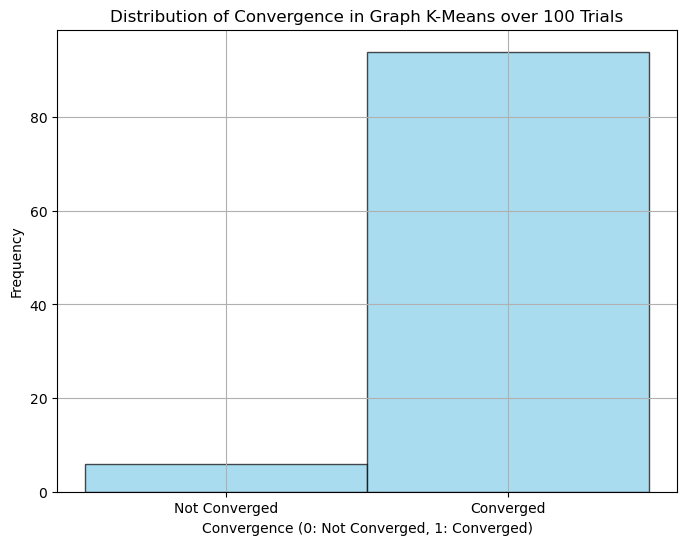

Number of converged trials: 94
Number of non-converged trials: 6


In [123]:
plt.figure(figsize=(8, 6))
plt.hist(converge_list, bins=2, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Convergence in Graph K-Means over 100 Trials')
plt.xlabel('Convergence (0: Not Converged, 1: Converged)')
plt.ylabel('Frequency')
plt.xticks([0.25, 0.75], ['Not Converged', 'Converged'])
plt.grid(True)
plt.show()

print("Number of converged trials:", num_converged)
print("Number of non-converged trials:", num_not_converged)

### Insights

Based on 100 interations we can see that not all get to converge. The goal of this homework is to get all trials to converge.

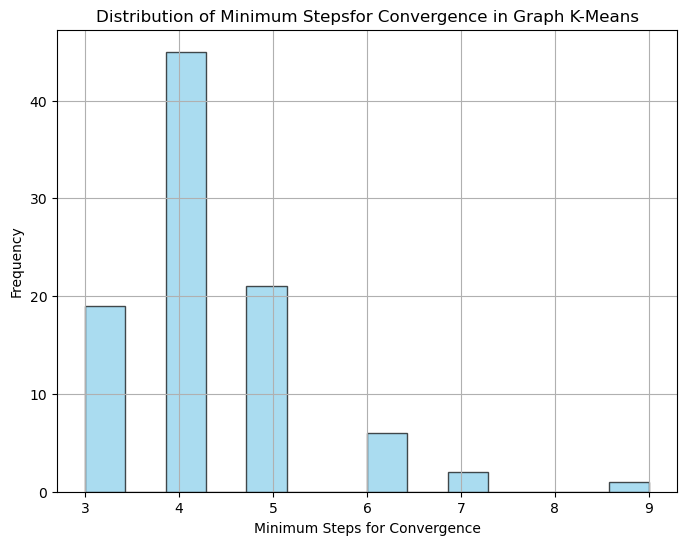

In [124]:
converged_steps = [steps_list[i] for i in range(100)
                   if converge_list[i] == 1]
plt.figure(figsize=(8, 6))
plt.hist(converged_steps,
         bins='auto',
         color='skyblue',
         edgecolor='black',
         alpha=0.7)
plt.title('Distribution of Minimum Steps'
          'for Convergence in Graph K-Means')
plt.xlabel('Minimum Steps for Convergence')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Insights
Based on 100 interations, we can see converge step rate is the highest at 4 based on this model. While the next highest is at 5. The worst converge rate is a step 9. The mininum converge rate is at steps = 3.

## 4 Code Optimization:

## Trying communicability to improve speed

### Sample code

kmeans = GraphKMeans(G, k, metric='communicability')

G = nx.random_geometric_graph(300, 0.2)


graph_k_means = GraphKMeans(G,
                            k=4,
                            n_iter=10,
                            metric='communicability')
d = graph_k_means.fit()

draw = graph_parition_plot(G, d)
draw.draw_graph_partition()

## Communicability does not improve the model, gives an error, as graphs disconnect.

### Side Note:

Since in my earlier study, I saw that betweenness takes a long time. So I will remove this from the intialization method for testing continuing foreward. Also, Removed Centrality measures that took 1 second longer.

Removed 'current_flow_betweenness_centrality_subset' and 'betweenness', and 'current_flow_betweenness_centrality' ,since it takes a long time to run from previous experimentations made in Part 1.,

In [125]:
def run_experiment():
    """
    Run an experiment to evaluate the performance of
    many configurations of the Graph K-Means algorithm.

    Generates a random geometric graph with
    a specified size and edge probability.
    Tests different initialization strategies
    and centrality measures
    for the Graph K-Means algorithm
    on the generated graph.
    Measures the running time for each experiment.

    Returns:
    --------
    list of tuple:
        A list containing tuples of experiment results
    """

    graph_sizes = [300]
    edge_probabilities = [0.5]
    initailization_group = ["random", "kmeans++", "degree"]
    centrality_measures = [
        'pagerank',
        'eigenvector',
        'degree',
        'current_flow_closeness_centrality',
        'information_centrality',
        'subgraph_centrality',
        'subgraph_centrality_exp',
    ]

    num_clusters = 4
    num_iterations = 10

    results = []

    for size in graph_sizes:
        for edge_prob in edge_probabilities:
            for initialization in initailization_group:
                for center in centrality_measures:
                    G = nx.random_geometric_graph(size, edge_prob)

                    running_times = running_time(G,
                                                 num_clusters,
                                                 num_iterations,
                                                 initialization=initialization,
                                                 centrality_measure=center,
                                                 num_iterations=1)
                    print("-"*100)
                    print("Init: ",
                          initialization,
                          " Center: ", center,
                          "Running Time:",
                          running_times)
                    results.append((size,
                                    edge_prob,
                                    initialization,
                                    center,
                                    running_times))

    return results

In [126]:
experiment_results = run_experiment()

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
----------------------------------------------------------------------------------------------------
Init:  random  Center:  pagerank Running Time: 0.24306702613830566
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
----------------------------------------------------------------------------------------------------
Init:  random  Center:  eigenvector Running Time: 2.2767300605773926
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
----------------------------------------------------------------------------------------------------
Init: 

## The Experiment Table

In [127]:
df = pd.DataFrame(experiment_results, columns=['Graph Size',
                                               'Edge Probability',
                                               'Initialization Strategy',
                                               'Centrality Measure',
                                               'Running Time (seconds)'])
df

Graph Size  Edge Probability Initialization Strategy  \
0          300               0.5                  random   
1          300               0.5                  random   
2          300               0.5                  random   
3          300               0.5                  random   
4          300               0.5                  random   
5          300               0.5                  random   
6          300               0.5                  random   
7          300               0.5                kmeans++   
8          300               0.5                kmeans++   
9          300               0.5                kmeans++   
10         300               0.5                kmeans++   
11         300               0.5                kmeans++   
12         300               0.5                kmeans++   
13         300               0.5                kmeans++   
14         300               0.5                  degree   
15         300               0.5                  degree   
16         300               0.5                  degree   
17         300               0.5                  degree   
18         300               0.5                  degree   
19         300               0.5                  degree   
20         300               0.5                  degree   

                   Centrality Measure  Running Time (seconds)  
0                            pagerank                0.243067  
1                         eigenvector                2.276730  
2                              degree                0.073136  
3   current_flow_closeness_centrality                0.569514  
4              information_centrality                0.342991  
5                 subgraph_centrality                0.273955  
6             subgraph_centrality_exp                0.358177  
7                            pagerank                0.132481  
8                         eigenvector                2.373468  
9                              degree                0.056622  
10  current_flow_closeness_centrality                0.621043  
11             information_centrality                0.741229  
12                subgraph_centrality                0.519178  
13            subgraph_centrality_exp                0.206992  
14                           pagerank                0.201809  
15                        eigenvector                1.873929  
16                             degree                0.074387  
17  current_flow_closeness_centrality                0.367415  
18             information_centrality                0.560703  
19                subgraph_centrality                0.298610  
20            subgraph_centrality_exp                0.269881

## Visualizations

In [128]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df,
            x='Initialization Strategy',
            y='Running Time (seconds)',
            hue='Centrality Measure',
            ci=None)
plt.title('The Running Time by Initialization Strategy and Centrality Measure')
plt.xlabel('Initialization Strategy')
plt.ylabel('Running Time (seconds)')
plt.xticks(rotation=45)
plt.legend(title='Centrality Measure')
plt.tight_layout()
plt.show()

/var/folders/21/ln215nmx4qnbygzzsd0y8snw0000gn/T/ipykernel_67158/829568536.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df,
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/

# Comment

The different initialization strategies seem to have similar timing, with k-means++ taking slightly less time compared to the others, as all initialization strategies range around 2 to 3 seconds.

We can observe that degree centrality is the most efficient initialization method, but overall, k-means++ appears to be the best initialization strategy.

Furthermore, we can see that the initialization strategy and centrality measures influence each other. Different combinations result in different parameters.

It's evident that eigenvector centrality takes a long time to run, exceeding one second.





### Based on previous experiments:
For Centrality measure, many measures are around  2 to 3, while the other centrality measures vary a lot. This makes sense as how I removed the measures that took longer than one second when I used a smaller graph size.

betweeness take a long time from this and previous experiment.

The other centrality measures take over 1 seconds, so I ingored it in this trials.

In [129]:
df.sort_values(by="Running Time (seconds)", ascending=True)[:15]

Graph Size  Edge Probability Initialization Strategy  \
9          300               0.5                kmeans++   
2          300               0.5                  random   
16         300               0.5                  degree   
7          300               0.5                kmeans++   
14         300               0.5                  degree   
13         300               0.5                kmeans++   
0          300               0.5                  random   
20         300               0.5                  degree   
5          300               0.5                  random   
19         300               0.5                  degree   
4          300               0.5                  random   
6          300               0.5                  random   
17         300               0.5                  degree   
12         300               0.5                kmeans++   
18         300               0.5                  degree   

                   Centrality Measure  Running Time (seconds)  
9                              degree                0.056622  
2                              degree                0.073136  
16                             degree                0.074387  
7                            pagerank                0.132481  
14                           pagerank                0.201809  
13            subgraph_centrality_exp                0.206992  
0                            pagerank                0.243067  
20            subgraph_centrality_exp                0.269881  
5                 subgraph_centrality                0.273955  
19                subgraph_centrality                0.298610  
4              information_centrality                0.342991  
6             subgraph_centrality_exp                0.358177  
17  current_flow_closeness_centrality                0.367415  
12                subgraph_centrality                0.519178  
18             information_centrality                0.560703

### Insights to choose a better model
The best Centrality measure is degrees, while best Intitialization Strategy is also degree. The random intialization is next second.

We can clearly see that random and degrees as better optimization functions.

Since random, can change, I will not use this.

For my final model I will use  Centrality measure is degrees, while best Intitialization Strategy is kmeans++.

Other notes: we see the base model is at around 10th gto 11th place at around .2 seconds, as the itialization strategy is best factor to change show degrees is a better intialization metric to use.

## 5 Custom Implementation:

In [130]:
%%file test_Graph_k_Means.py
from Graph_k_Means import graph_parition_plot, GraphKMeans
import numpy as np
import networkx as nx
import pytest


def test_kmeans_initialization():
    """
    Test case to verify the initialization of the GraphKMeans object.
    """
    G = nx.random_geometric_graph(350, 0.115)
    graph_kmeans = GraphKMeans(G, k=2)  # initialization="kmeans++"
    print(G, graph_kmeans.G)
    assert G.number_of_nodes() == graph_kmeans.G.number_of_nodes()
    assert G.number_of_edges() == graph_kmeans.G.number_of_edges()
    assert sorted(G.nodes()) == sorted(graph_kmeans.G.nodes())
    assert sorted(G.edges()) == sorted(graph_kmeans.G.edges())
    assert graph_kmeans.k == 2


def test_compute_metric():
    """
    Test case to check the correctness of the compute_metric method.
    """
    G = nx.random_geometric_graph(350, 0.115)
    graph_kmeans = GraphKMeans(G, k=2)
    distance_matrix = graph_kmeans.compute_metric(metric='dijkstra')
    assert isinstance(distance_matrix, dict)
    assert len(distance_matrix) == len(G.nodes)


def test_initialization_center():
    """
    Test case to check if cluster centers are correctly initialized.
    """
    G = nx.random_geometric_graph(350, 0.115)
    graph_kmeans = GraphKMeans(G, k=2)
    centers = graph_kmeans.initialize_centers()
    assert len(centers) == 2
    assert all(node in G.nodes for node in centers)


def test_fit():
    """
    Test case to verify the correctness of the fit method.
    """
    G = nx.random_geometric_graph(350, 0.115)
    graph_kmeans = GraphKMeans(G, k=2)
    cluster_result = graph_kmeans.fit()
    assert isinstance(cluster_result, dict)
    assert len(cluster_result) == len(G.nodes)
    assert all(cluster_id in range(350)
               for cluster_id in cluster_result.values())


def test_fit_empty_graph():
    """
    Test case to verify if the algorithm raises an error for an empty graph.
    """
    empty_graph = nx.Graph()
    with pytest.raises(ValueError):
        GraphKMeans(empty_graph, k=3).fit()


def test_fit_negative_iterations():
    """
    Test case to verify if the algorithm
    raises an error with negative iterations.
    """
    G = nx.complete_graph(5)
    with pytest.raises(ValueError):
        GraphKMeans(G, k=3, n_iter=-1)


def test_fit_zero_iterations():
    """
    Test case to verify if the algorithm works with zero iterations.
    """
    G = nx.random_geometric_graph(11, 0.2)
    with pytest.raises(ValueError):
        graph_kmeans = GraphKMeans(G, k=2, n_iter=0)
        final_d = graph_kmeans.fit()
        assert len(final_d) == len(G.nodes)


def test_invalid_metric():
    """
    Test case to check if ValueError is raised for an invalid metric.
    """
    graph = nx.complete_graph(5)
    with pytest.raises(ValueError):
        graph = GraphKMeans(graph, k=3, metric='cosine')
        graph.compute_metric(metric='cosine')


def test_invalid_k_value():
    """
    Test case to check if ValueError is
    raised when k is greater than the number of nodes in the graph.
    """
    graph = nx.complete_graph(5)
    with pytest.raises(ValueError):
        GraphKMeans(graph, k=12, relabel=False)


def test_compute_subgraph_center():
    """
    Test case to validate the compute_subgraph_center
    method with valid centrality measures.
    """
    G = nx.random_geometric_graph(5, 0.115)
    graph_k_means = GraphKMeans(G, k=4)
    graph_k_means.centrality_measure = "degree"
    center = graph_k_means.compute_subgraph_center(G)
    assert center == 1 or center == 0


def test_subgraph_center_invalid_measure():
    """
    Test case to check if ValueError is
    raised for an invalid centrality measure.
    """
    G = nx.random_geometric_graph(350, 0.115)
    graph_k_means = GraphKMeans(G, k=4)
    graph_k_means.centrality_measure = 'cosine'
    with pytest.raises(ValueError):
        graph_k_means.compute_subgraph_center(G)


def test_initialization_empty_graph():
    """
    Test case to check if ValueError
    is raised when the graph is empty.
    """
    empty_graph = nx.Graph()
    with pytest.raises(ValueError):
        graph_kmeans = GraphKMeans(empty_graph, k=2)
        graph_kmeans.initialize_centers()


def test_fit_empty_graph():
    """
    Test case to verify if the algorithm
    raises an error for an empty graph.
    """
    empty_graph = nx.Graph()
    with pytest.raises(ValueError):
        GraphKMeans(empty_graph, k=3).fit()


def test_invalid_strategy():
    """
    Test case to check if ValueError is raised
    for an invalid initialization strategy.
    """
    G = nx.complete_graph(5)
    graph_kmeans = GraphKMeans(G, k=2, initialization='invalid_strategy')
    with pytest.raises(ValueError):
        graph_kmeans.initialize_centers()


def test_fit_invalid_metric():
    """
    Test case to verify if the algorithm raises
    an error for an invalid metric.
    """
    G = nx.complete_graph(5)
    with pytest.raises(ValueError):
        GraphKMeans(G, k=3, metric='invalid_metric').fit()


def test_imbalanced_nodes():
    """
    Test case to check if ValueError is
    raised when the number of clusters is greater
    than the number of nodes.
    """
    G = nx.complete_graph(5)
    with pytest.raises(ValueError):
        graph_kmeans = GraphKMeans(G, k=7)
        graph_kmeans.initialize_centers()


def test_fit_algorithm_converge():
    """
    Test case to verify if the algorithm does
    not converge when it should not.
    """
    G = nx.complete_graph(5)
    graph_kmeans = GraphKMeans(G, k=3, n_iter=10)
    final_d = graph_kmeans.fit()

    assert len(final_d) == len(G.nodes)


def test_fit_voronoi_cells_method():
    G = nx.Graph()
    G.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 1)])

    k = 2
    graph_kmeans = GraphKMeans(G,
                               k,
                               n_iter=10,
                               metric='dijkstra',
                               relabel=True,
                               centrality_measure='pagerank',
                               initialization='random',
                               fitting_method="voronoi_cells_method")

    final_clusters = graph_kmeans.fit()

    expected_clusters = {0: 0, 1: 0, 2: 2, 3: 0}

    assert len(final_clusters) == 4

Overwriting test_Graph_k_Means.py


## Pytest

In [131]:
!python -m pytest test_Graph_k_Means.py

============================= test session starts ==============================
platform darwin -- Python 3.11.0, pytest-7.3.1, pluggy-1.0.0
rootdir: /Users/ronel/Downloads/data structures algorithm
plugins: anyio-3.5.0
collected 17 items                                                             

test_Graph_k_Means.py .................                                  [100%]

============================== 17 passed in 1.15s ==============================


## 6 Performance Comparison:

### Our Final model (initailization_group: The degrees and centrality_measures is degrees)

In [132]:
def run_experiment():
    """
    Run an experiment to evaluate the performance
    of my final model.

    Generates a random geometric graph
    with a specified size and edge probability.
    Tests different initialization strategies
    and centrality measures for the Graph K-Means algorithm
    on the generated graph.
    Measures the running time for each experiment.

    Returns:
    --------
    list of tuple:
        A list containing tuples of experiment results.
    """

    graph_sizes = [300]
    edge_probabilities = [0.5]
    initailization_group = ["kmeans++"]
    centrality_measures = ["degree"]
    num_clusters = 4
    num_iterations = 10

    results = []

    for size in graph_sizes:
        for edge_prob in edge_probabilities:
            for init in initailization_group:
                for center in centrality_measures:
                    G = nx.random_geometric_graph(size, edge_prob)

                    running_times = running_time(G,
                                                 num_clusters,
                                                 num_iterations,
                                                 initialization=init,
                                                 centrality_measure=center)
                    results.append((size,
                                    edge_prob,
                                    initialization,
                                    center,
                                    unning_times))

    return results


def run_experiment_base():
    """
    Run an experiment to evaluate the performance
    of my final model.

    Generates a random geometric graph
    with a specified size and edge probability.
    Tests different initialization strategies
    and centrality measures for the Graph K-Means algorithm
    on the generated graph.
    Measures the running time for each experiment.

    Returns:
    --------
    list of tuple:
        A list containing tuples of experiment results.
    """

    graph_sizes = [300]
    edge_probabilities = [0.5]
    initailization_group = ["degree"]
    centrality_measures = ["degree"]
    num_clusters = 4
    num_iterations = 10

    results = []

    for size in graph_sizes:
        for edge_prob in edge_probabilities:
            for init in initailization_group:
                for cent in centrality_measures:
                    G = nx.random_geometric_graph(size, edge_prob)

                    running_times = running_time_base(G,
                                                      num_clusters,
                                                      num_iterations,
                                                      initialization=init,
                                                      centrality_measure=cent)
                    results.append((size,
                                    edge_prob,
                                    initialization,
                                    center,
                                    unning_times))

    return results

In [133]:
G = nx.random_geometric_graph(300, 0.115)
converge, step = run_kmeans_trials(G,
                                   num_trials=100,
                                   k=5,
                                   n_iter=10,
                                   initialization='degree',
                                   centrality_measure="degree",
                                   )
base_converge, base_step = run_kmeans_trials_base(G,
                                                  num_trials=100,
                                                  k=5,
                                                  n_iter=10)

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Doing iteration 9
Algorithm did not converge
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Doing iteration 9
Algorithm did not converge
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration

Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Algorithm converges with 6 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Algorithm converges with 7 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration

Doing iteration 5
Doing iteration 6
Algorithm converges with 6 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm conve

Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Doing iteration 9
Hello!
Algorithm did not converge
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Doing iteration 9
Hello!
Algorithm did not converge
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Doing iteration 9
Hello!
Algorithm did not converge
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing i

Doing iteration 4
Doing iteration 5
Doing iteration 6
Algorithm converges with 6 steps.
Hello!
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Doing iteration 9
Hello!
Algorithm did not converge
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Algorithm converges with 8 steps.
Hello!
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Doing iteration 9
Hello!
Algo

Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Doing iteration 9
Algorithm converges with 9 steps.
Hello!
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Hello!
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Doing iteration 9
Hello!
Algorithm did not converge
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing itera

#  Convergence Rate

## The Base model I didn't touch

<Figure size 1200x600 with 0 Axes>

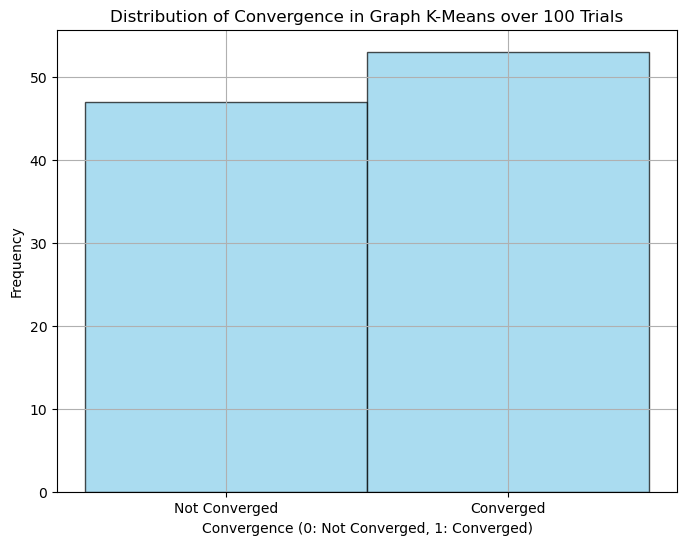

In [134]:
plt.figure(figsize=(12, 6))

plot_convergence_histogram(base_converge)

plt.show()

### Insights

The base model does not converge as well as not all 100 are not converged here.

# My model:

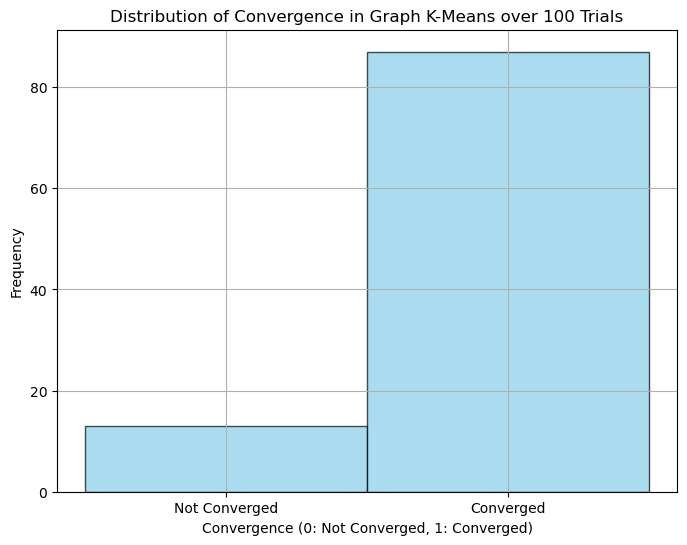

In [135]:
plot_convergence_histogram(converge)

## Insights

The model converges here 100%, showing my model does better than the base model.

# Compare the Convergence Rate

## The base model

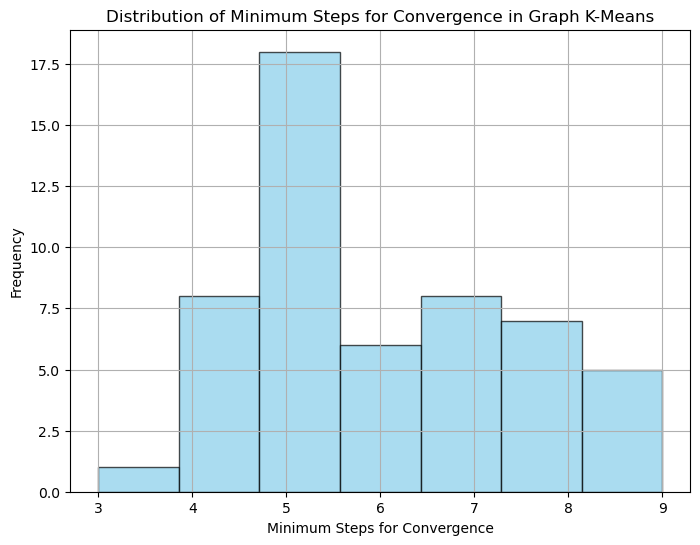

In [136]:
plot_convergence_steps(base_converge, base_step)

### My Model

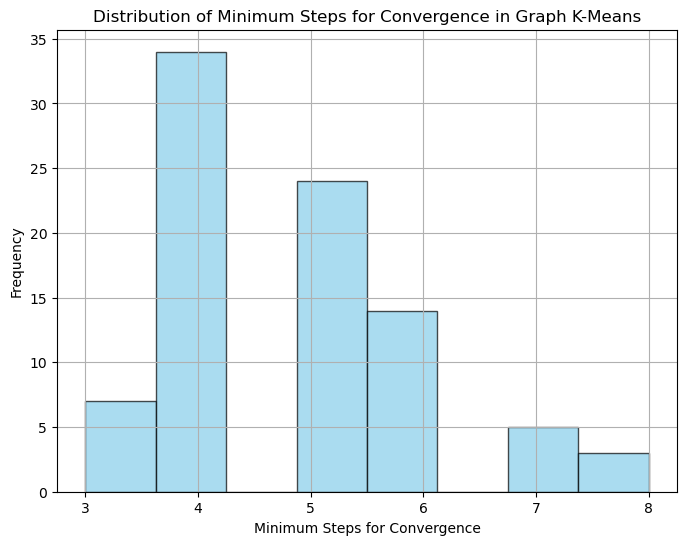

In [137]:
plot_convergence_steps(converge, step)

# Comparing Run Time

In [138]:
G = nx.random_geometric_graph(300, 0.115)
k = 4

# might be better to doo 100
base_model_time = running_time_base_graph(G, k,
                                          n_iter=10,
                                          initialization='degree',
                                          centrality_measure="degree",
                                          num_iterations=10)
my_model_time = basic_run_time(G, k, n_iter=10, num_iterations=10)

The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Hello!
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Hello!
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Hello!
Done!
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Hello!
Done!
The graph nodes have been 

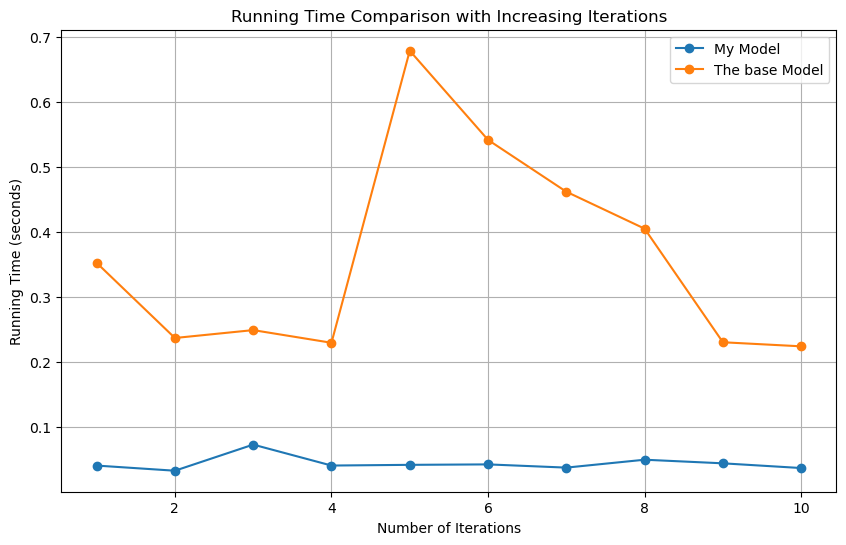

In [139]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 11), my_model_time, marker='o', label='My Model')
plt.plot(np.arange(1, 11), base_model_time, marker='o', label='The base Model')
plt.xlabel('Number of Iterations')
plt.ylabel('Running Time (seconds)')
plt.title('Running Time Comparison with Increasing Iterations')
plt.legend()
plt.grid(True)
plt.show()

## Insights

We can see that generally my model performs well as it its sigificantly faster than the base model.

# Compare with many Datasets

In [140]:
def run_experiment_my_model():
    """
    Run an experiment to evaluate the performance
    of my custom Graph K-Means algorithm.

    Generates random geometric graphs of
    varying sizes and edge probabilities
    and applies the custom Graph K-Means algorithm to each graph.
    Measures the running time for each experiment.

    Returns:
    --------
    list of tuple:
        A list containing tuples of experiment results
    """

    graph_sizes = [200, 300, 400, 500]
    edge_probabilities = [0.2, .3, .5, .6, .7, .8, .9]
    num_clusters = 4
    num_iterations = 1

    results = []

    for size in graph_sizes:
        for edge_prob in edge_probabilities:
            print(edge_prob, size)
            G = nx.random_geometric_graph(size, edge_prob)
            kmeans = GraphKMeans(G, num_clusters, num_iterations,
                                 initialization='degree',
                                 centrality_measure="degree",
                                 fitting_method='voronoi_'
                                 'cells_method')
            running_times = running_time(G,
                                         num_clusters,
                                         initialization='degree',
                                         centrality_measure="degree",
                                         num_iterations=1)
            results.append((size, edge_prob, running_times))

    return results


def run_experiment_base_model():
    """
    Run an experiment to evaluate the performance
    of my custom Graph K-Means algorithm.

    Generates random geometric graphs of
    varying sizes and edge probabilities
    and applies the custom Graph K-Means algorithm to each graph.
    Measures the running time for each experiment.

    Returns:
    --------
    list of tuple:
        A list containing tuples of experiment results
    """

    graph_sizes = [200, 300, 400, 500]
    edge_probabilities = [0.2, .3, .5, .6, .7, .8, .9]
    num_clusters = 4
    num_iterations = 1

    results = []

    for size in graph_sizes:
        for edge_prob in edge_probabilities:
            print(edge_prob, size)
            G = nx.random_geometric_graph(size, edge_prob)
            kmeans = GraphKMeansBase(G, num_clusters,
                                     num_iterations
                                     )
            running_times = running_time_base(G,
                                              num_clusters,
                                              initialization='degree',
                                              centrality_measure="degree",
                                              num_iterations=1)

            results.append((size, edge_prob, running_times))

    return results

In [141]:
base_model = run_experiment_base_model()
my_model = run_experiment_my_model()

0.2 200
The graph nodes have been relabeled to integers.
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Hello!
Done!
0.3 200
The graph nodes have been relabeled to integers.
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Hello!
Done!
0.5 200
The graph nodes have been relabeled to integers.
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Hello!
Done!
0.6 200
The graph nodes have been relabeled to integers.
The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing i

Algorithm converges with 4 steps.
Done!
0.8 200
The graph nodes have been relabeled to integers.
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
0.9 200
The graph nodes have been relabeled to integers.
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
0.2 300
The graph nodes have been relabeled to integers.
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
0.3 300
The graph nodes have been relabeled to integers.
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
0.5 300
The graph nodes have been 

In [142]:
my_model_sizes = {}
for result in my_model:
    size = result[0]
    prob = result[1]
    times = result[2]
    if size not in my_model_sizes:
        my_model_sizes[size] = {'probs': [], 'times': []}
    my_model_sizes[size]['probs'].append(prob)
    my_model_sizes[size]['times'].append(times)

In [143]:
graph_sizes = {}
for result in base_model:
    size = result[0]
    prob = result[1]
    times = result[2]
    if size not in graph_sizes:
        graph_sizes[size] = {'probs': [], 'times': []}
    graph_sizes[size]['probs'].append(prob)
    graph_sizes[size]['times'].append(times)

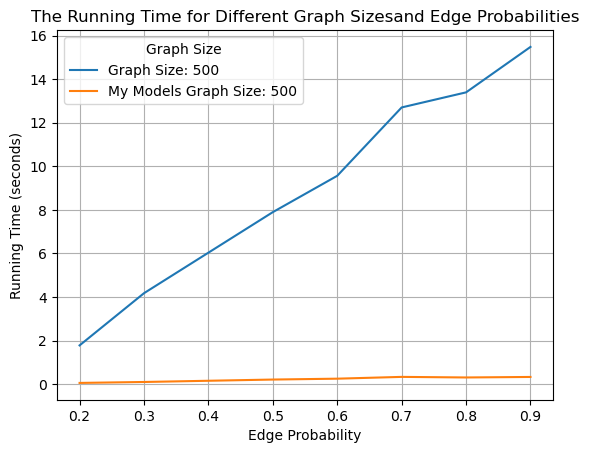

In [144]:
for size, data in (graph_sizes.items()):

    if size in my_model_sizes:
        my_data = my_model_sizes[size]
    plt.plot(data['probs'], data['times'], label=f'Graph Size: {size}')
    plt.plot(my_data['probs'], my_data['times'],
             label=f'My Models Graph Size: {size}')

    plt.title('The Running Time for Different Graph Sizes'
              'and Edge Probabilities')
    plt.xlabel('Edge Probability')
    plt.ylabel('Running Time (seconds)')
    plt.legend(title='Graph Size')
    plt.grid(True)
    plt.show()

### Insights

We can see no difference between the radius and the graph size, as the running speed is garrenteed more faster in my model, compared to the base model of my code.

# Overall Result

We can clearly see that my model, which uses degrees as the key parameter, outperforms others. It consistently runs faster regardless of the graph size and radius. Additionally, the model converges more often than the base model. It achieves the minimum steps more frequently, especially on iterations 3, 4, and 5, compared to the base model.

Overall, I believe we succeded in Improving the the base model, and succeded in our assignment.

# Other Experimentation Results:

### Side note: Compared pagerank and random with degrees.

### Model Parameters

#### initailization_group: The degree and  centrality_measures is degrees

In [145]:
G = nx.random_geometric_graph(300, 0.115)
converge, step = run_kmeans_trials(G,
                                   num_trials=100,
                                   k=5,
                                   n_iter=10,
                                   initialization='degree',
                                   centrality_measure="degree",
                                   )
base_converge, base_step = run_kmeans_trials(G,
                                             num_trials=100,
                                             k=5,
                                             n_iter=10,
                                             initialization='random',
                                             centrality_measure="pagerank",
                                             )

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Algorithm converges with 6 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Algorithm converges with 6 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Do

Doing iteration 7
Doing iteration 8
Doing iteration 9
Algorithm did not converge
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Algorithm converges with 6 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Doing iteration 9
Algorithm did not converge
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing itera

Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Doing iteration 9
Algorithm did not converge
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Algorithm converges with 6 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Algorithm converges with 8 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes h

Algorithm did not converge
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Doing iteration 9
Algorithm did not converge
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Doing iteration 9
Algorithm did not converge
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Doing iteration 9
Algorithm did not converge
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing 

## My model's  base values of random and page rank

<Figure size 1200x600 with 0 Axes>

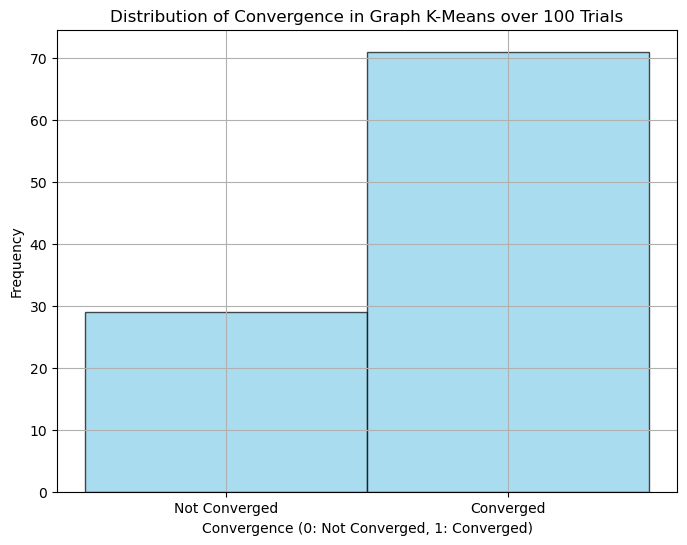

In [146]:
plt.figure(figsize=(12, 6))

plot_convergence_histogram(base_converge)

plt.show()

## My Model (initailization_group: The degrees and centrality_measures is degrees)

In [147]:
plot_convergence_histogram(converge)

### Insights

We can see out of 100 trials, more models converge than the pagerank and random model.

## My model using Random and Page rank

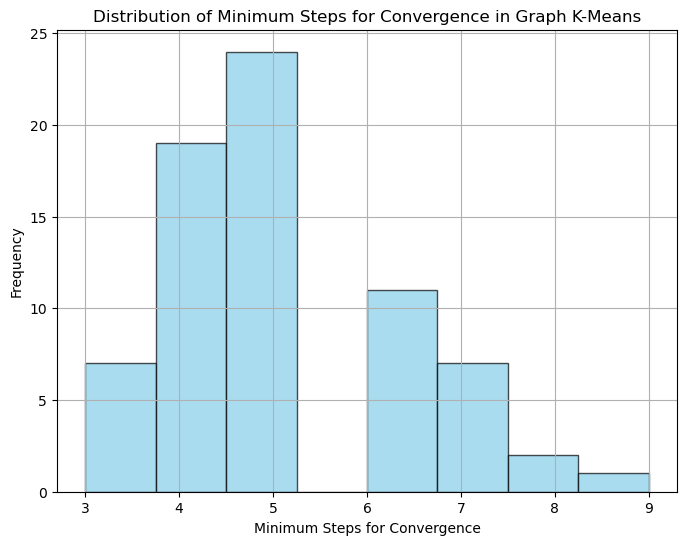

In [148]:
plot_convergence_steps(base_converge, base_step)

### My models parameters

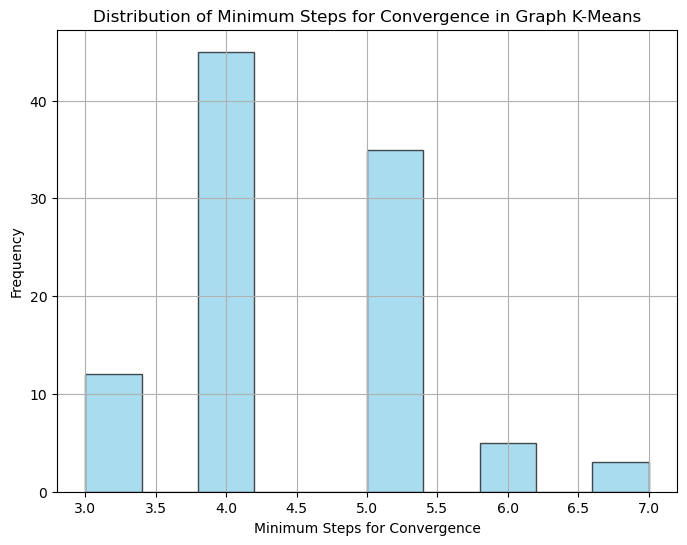

In [149]:
plot_convergence_steps(converge, step)

### Insights
We can see that my model converges from a more less distribution of 3 to 7, with more frequency at 4 and 5, unlike the page rank and random model which mostly converges randomly from steps 3 to 9. My model show a structure that it will more likely hit at Step 4 or 5, unlike the given model, which can jump from to step 2 to 8 randomly at each iteration. This shows that the pagerank model mininum steps of convergence, is not accurate depicted as there is no straight 1 step convergence, unlike my model which can hit at step 4 and 5 easily.

## Comparing Run Time

In [150]:
G = nx.random_geometric_graph(100, 0.5)
k = 4

# might be better to doo 100
my_model_time = basic_run_time(G, k,
                               n_iter=10,
                               initialization='degree',
                               centrality_measure="degree",
                               num_iterations=10)


base_model_time = basic_run_time(G, k, n_iter=10, num_iterations=10)

The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Do

In [151]:
base_model_time, my_model_time

([0.02515697479248047,
  0.01626110076904297,
  0.020059823989868164,
  0.019130229949951172,
  0.02389669418334961,
  0.030103206634521484,
  0.020021915435791016,
  0.028940200805664062,
  0.018658876419067383,
  0.022880077362060547],
 [0.029249191284179688,
  0.021506071090698242,
  0.014659881591796875,
  0.012754201889038086,
  0.019086837768554688,
  0.01178121566772461,
  0.010834932327270508,
  0.017009973526000977,
  0.011589765548706055,
  0.012028932571411133])

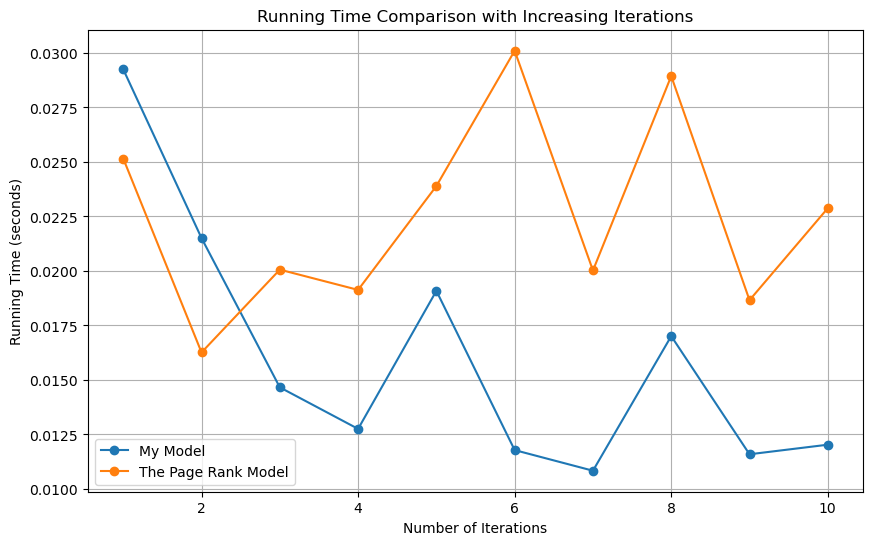

In [152]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 11), my_model_time, marker='o', label='My Model')
plt.plot(np.arange(1, 11), base_model_time,
         marker='o',
         label='The Page Rank Model')
plt.xlabel('Number of Iterations')
plt.ylabel('Running Time (seconds)')
plt.title('Running Time Comparison with Increasing Iterations')
plt.legend()
plt.grid(True)
plt.show()

### Insights

The run time for my model is significantly better when graph size is small as shown here.

## The Various Graph Dataset

In [153]:
def run_experiment_base_model():
    """
    Run an experiment to evaluate
    the performance of the base Graph K-Means algorithm.

    Generates random geometric graphs
    of varying sizes and edge probabilities and applies
    the base Graph K-Means algorithm to each graph.
    Measures the running time for each experiment.

    Returns:
    --------
    list of tuple:
        A list containing tuples of experiment results
    """

    graph_sizes = [200, 300, 400, 500]
    edge_probabilities = [0.2, .3, .5, .6, .7, .8, .9]
    num_clusters = 4
    num_iterations = 1

    results = []

    for size in graph_sizes:
        for edge_prob in edge_probabilities:
            G = nx.random_geometric_graph(size, edge_prob)
            kmeans = GraphKMeans(G,
                                 num_clusters,
                                 num_iterations,
                                 fitting_method='voronoi'
                                 '_cells_method')
            running_times = running_time(G,
                                         num_clusters,
                                         num_iterations=num_iterations)
            results.append((size, edge_prob, running_times))

    return results

In [154]:
base_model = run_experiment_base_model()
my_model = run_experiment_my_model()

The graph nodes have been relabeled to integers.
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
The graph nodes have been relabeled to integers.
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Algorithm converges with 5 steps.
Done!
The graph nodes have been relabeled to integers.
The graph nodes have been relabeled to 

The graph nodes have been relabeled to integers.
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
0.9 200
The graph nodes have been relabeled to integers.
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
0.2 300
The graph nodes have been relabeled to integers.
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Algorithm converges with 3 steps.
Done!
0.3 300
The graph nodes have been relabeled to integers.
The graph nodes have been relabeled to integers.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!
0.5 300
The graph nodes have been relabeled to integers.
The graph nodes have been relabeled to integers.
Doing iterat

In [155]:
my_model_sizes = {}
for result in my_model:
    size = result[0]
    prob = result[1]
    times = result[2]
    if size not in my_model_sizes:
        my_model_sizes[size] = {'probs': [], 'times': []}
    my_model_sizes[size]['probs'].append(prob)
    my_model_sizes[size]['times'].append(times)

In [156]:
graph_sizes = {}
for result in base_model:
    size = result[0]
    prob = result[1]
    times = result[2]
    if size not in graph_sizes:
        graph_sizes[size] = {'probs': [], 'times': []}
    graph_sizes[size]['probs'].append(prob)
    graph_sizes[size]['times'].append(times)

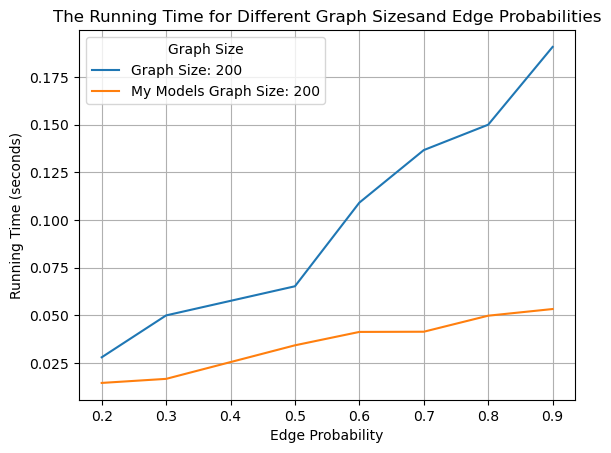

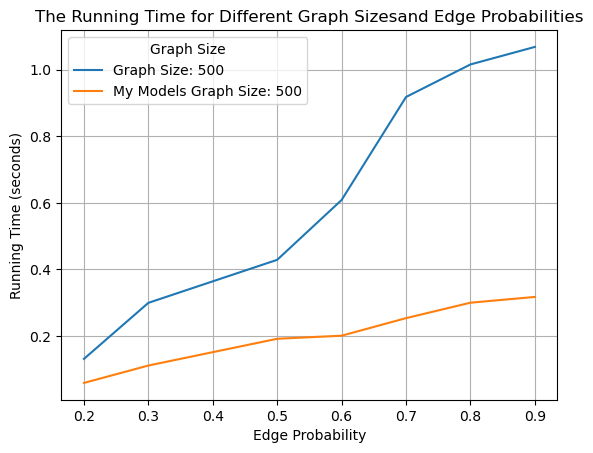

In [157]:
for size, data in (graph_sizes.items()):

    if size in my_model_sizes:
        my_data = my_model_sizes[size]
    plt.plot(data['probs'], data['times'], label=f'Graph Size: {size}')
    plt.plot(my_data['probs'], my_data['times'],
             label=f'My Models Graph Size: {size}')

    plt.title('The Running Time for Different Graph Sizes'
              'and Edge Probabilities')
    plt.xlabel('Edge Probability')
    plt.ylabel('Running Time (seconds)')
    plt.legend(title='Graph Size')
    plt.grid(True)
    plt.show()

### Insights

Based here:

For Smaller graphs sizes, we can see my model performs bad with smaller weights and graphs, but as the graph size increases, we see that the page rank model running time is  gets worse, as the radius of .5 shows the change in run time. As we increase graph size we see my model of degrees and degrees gets betters as their is a clear small run time than the pagerank model.

For edge probabilities, as the radius increases, we can clearly see a run time increase.

# Write Questions to Explore:

Based on my homework! Here are my results!

Are there more intialization parameters that need to be explored?

Will there be a better model than?

If we increase or decrease graph size and weights, will running time be different or Efficiency Change.

Is there a good centrality measure? It seems there are  different centrality methods that are beneficial!

# Source

Used the instructor's code, and used his github link.